## Group_project, team=Mining potatoes

In [2]:
library(GGally)
library(ggplot2)
library(mvtnorm)
library(corrplot)
library(caret)
library(graphics)
library(NbClust)
library(ggmap)
library(hflights)
library(DT)
library(prettyR)
library(psych)
library(nortest)
library(car)
library(lm.beta)
library(usdm)
library(zoo) 
library(lmtest)

Loading required package: sp
Loading required package: raster

Attaching package: ‘raster’

The following object is masked from ‘package:prettyR’:

    freq


Attaching package: ‘usdm’

The following object is masked from ‘package:car’:

    vif


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [3]:
House <- readxl::read_excel(path="Desktop/R/RStudio/kc_house_data.xlsx",
                            sheet=1,
                            col_names=TRUE)

In [4]:
str(House)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	21613 obs. of  21 variables:
 $ id           : num  7.13e+09 6.41e+09 5.63e+09 2.49e+09 1.95e+09 ...
 $ date         : chr  "20141013T000000" "20141209T000000" "20150225T000000" "20141209T000000" ...
 $ price        : num  221900 538000 180000 604000 510000 ...
 $ bedrooms     : num  3 3 2 4 3 4 3 3 3 3 ...
 $ bathrooms    : num  1 2.25 1 3 2 4.5 2.25 1.5 1 2.5 ...
 $ sqft_living  : num  1180 2570 770 1960 1680 ...
 $ sqft_lot     : num  5650 7242 10000 5000 8080 ...
 $ floors       : num  1 2 1 1 1 1 2 1 1 2 ...
 $ waterfront   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ view         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ condition    : num  3 3 3 5 3 3 3 3 3 3 ...
 $ grade        : num  7 7 6 7 8 11 7 7 7 7 ...
 $ sqft_above   : num  1180 2170 770 1050 1680 ...
 $ sqft_basement: num  0 400 0 910 0 1530 0 0 730 0 ...
 $ yr_built     : num  1955 1951 1933 1965 1987 ...
 $ yr_renovated : num  0 1991 0 0 0 ...
 $ zipcode      : num  98178 98125 98028 98136 9807

## 변수 기본 정보 확인

In [5]:
summary(House) 

       id                date               price            bedrooms     
 Min.   :1.000e+06   Length:21613       Min.   :  75000   Min.   : 0.000  
 1st Qu.:2.123e+09   Class :character   1st Qu.: 321950   1st Qu.: 3.000  
 Median :3.905e+09   Mode  :character   Median : 450000   Median : 3.000  
 Mean   :4.580e+09                      Mean   : 540088   Mean   : 3.371  
 3rd Qu.:7.309e+09                      3rd Qu.: 645000   3rd Qu.: 4.000  
 Max.   :9.900e+09                      Max.   :7700000   Max.   :33.000  
   bathrooms      sqft_living       sqft_lot           floors     
 Min.   :0.000   Min.   :  290   Min.   :    520   Min.   :1.000  
 1st Qu.:1.750   1st Qu.: 1427   1st Qu.:   5040   1st Qu.:1.000  
 Median :2.250   Median : 1910   Median :   7618   Median :1.500  
 Mean   :2.115   Mean   : 2080   Mean   :  15107   Mean   :1.494  
 3rd Qu.:2.500   3rd Qu.: 2550   3rd Qu.:  10688   3rd Qu.:2.000  
 Max.   :8.000   Max.   :13540   Max.   :1651359   Max.   :3.500  
   wat

 ## 원본 데이터 보존

In [6]:
House2 <- as.data.frame(House) 

In [7]:
str(House2)

'data.frame':	21613 obs. of  21 variables:
 $ id           : num  7.13e+09 6.41e+09 5.63e+09 2.49e+09 1.95e+09 ...
 $ date         : chr  "20141013T000000" "20141209T000000" "20150225T000000" "20141209T000000" ...
 $ price        : num  221900 538000 180000 604000 510000 ...
 $ bedrooms     : num  3 3 2 4 3 4 3 3 3 3 ...
 $ bathrooms    : num  1 2.25 1 3 2 4.5 2.25 1.5 1 2.5 ...
 $ sqft_living  : num  1180 2570 770 1960 1680 ...
 $ sqft_lot     : num  5650 7242 10000 5000 8080 ...
 $ floors       : num  1 2 1 1 1 1 2 1 1 2 ...
 $ waterfront   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ view         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ condition    : num  3 3 3 5 3 3 3 3 3 3 ...
 $ grade        : num  7 7 6 7 8 11 7 7 7 7 ...
 $ sqft_above   : num  1180 2170 770 1050 1680 ...
 $ sqft_basement: num  0 400 0 910 0 1530 0 0 730 0 ...
 $ yr_built     : num  1955 1951 1933 1965 1987 ...
 $ yr_renovated : num  0 1991 0 0 0 ...
 $ zipcode      : num  98178 98125 98028 98136 98074 ...
 $ lat          : num 

## 사용하지 않는 id, date 변수를 삭제

In [8]:
House2[1:2] <- NULL 

## N>20000, 실험데이터, 검증데이터 구분
# Splitting the Data Set 

In [9]:
ratio = sample(1:nrow(House2), size = 0.25*nrow(House2))

In [10]:
Test = House2[ratio,] #Test dataset 25% of total

In [11]:
Training = House2[-ratio,] #Train dataset 75% of total

##############################################
## <STEP1>           데이터 전처리              ##
###############################################

## 1. 전체 데이터의 분포와 상관관계를 살펴본다

## (1)  ggpairs()의 플롯을 활용해 각 데이터의 분포 확인

In [ ]:
plot(House2)

## ggpair()를 활용해 플롯을 그릴때
## 로딩 시간을 감안하여 그룹별로 구분지어 실시한다.

In [12]:
plot_g1 <- ggpairs(data=Training, columns=c(1:5),
                   mapping = aes(color = "dark green"),
                   axisLabels="show")

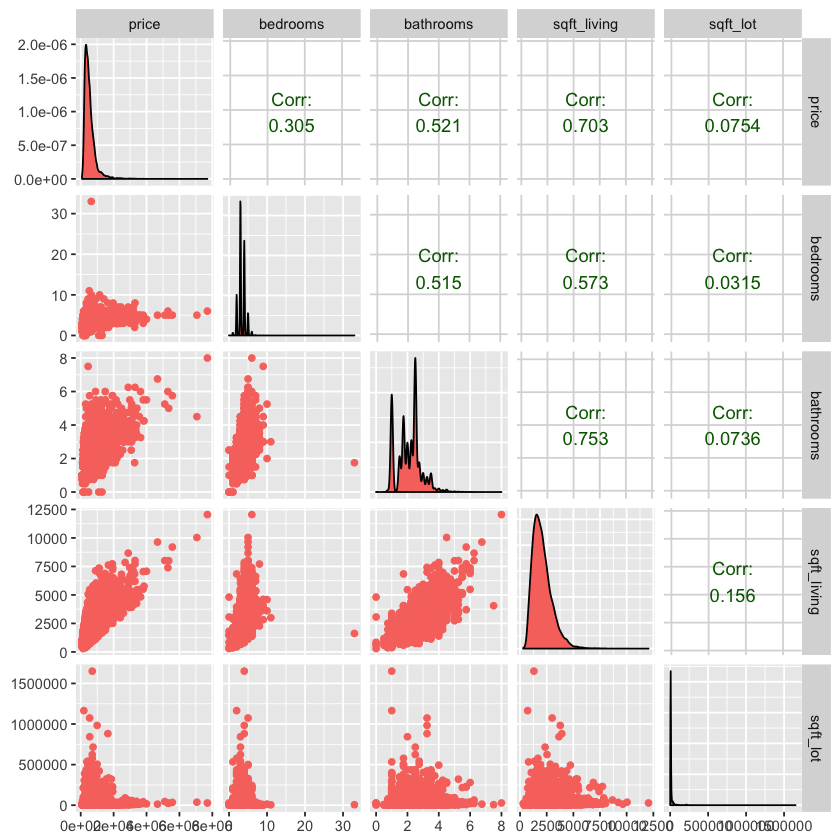

In [13]:
plot_g1

In [14]:
plot_g2 <- ggpairs(data=Training, columns=c(1,6:10),
                   mapping = aes(color = "dark green"),
                   axisLabels="show")

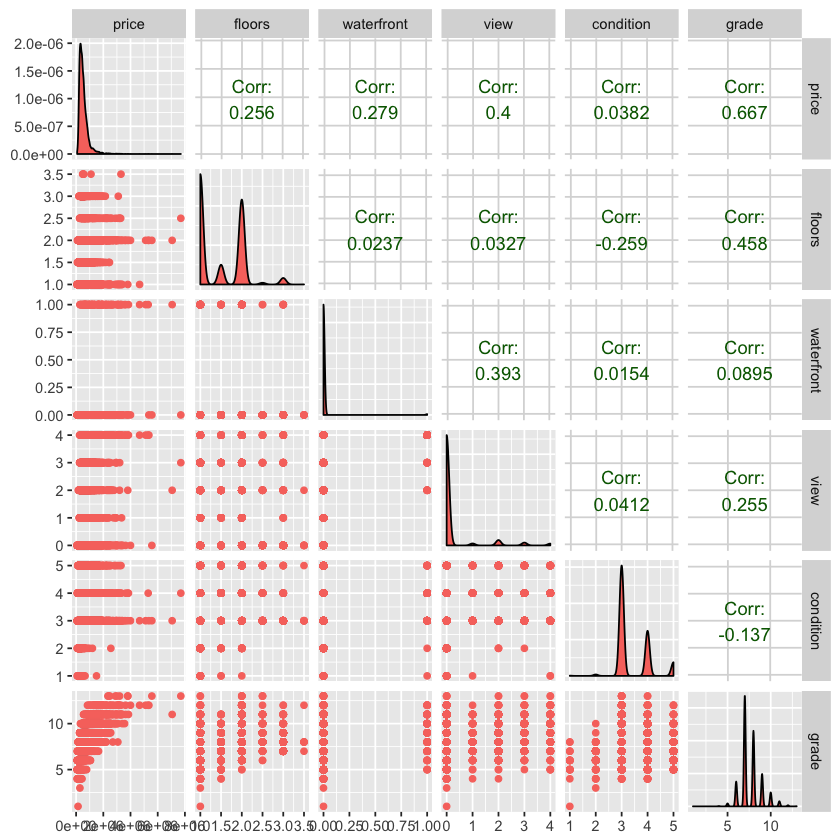

In [15]:
plot_g2

In [16]:
plot_g3 <- ggpairs(data=Training, columns=c(1,11:17),
                   mapping = aes(color = "dark green"),
                   axisLabels="show")

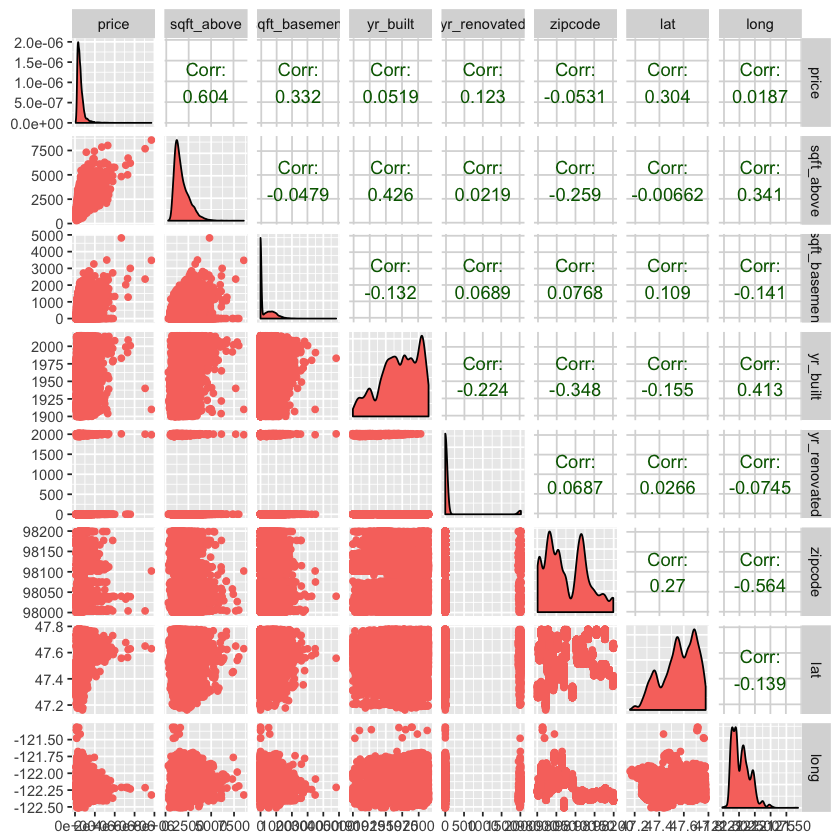

In [17]:
plot_g3

In [18]:
plot_g4 <- plot_g3 <- ggpairs(data=Training, columns=c(1,18:19),
                              mapping = aes(color = "dark green"),
                              axisLabels="show")

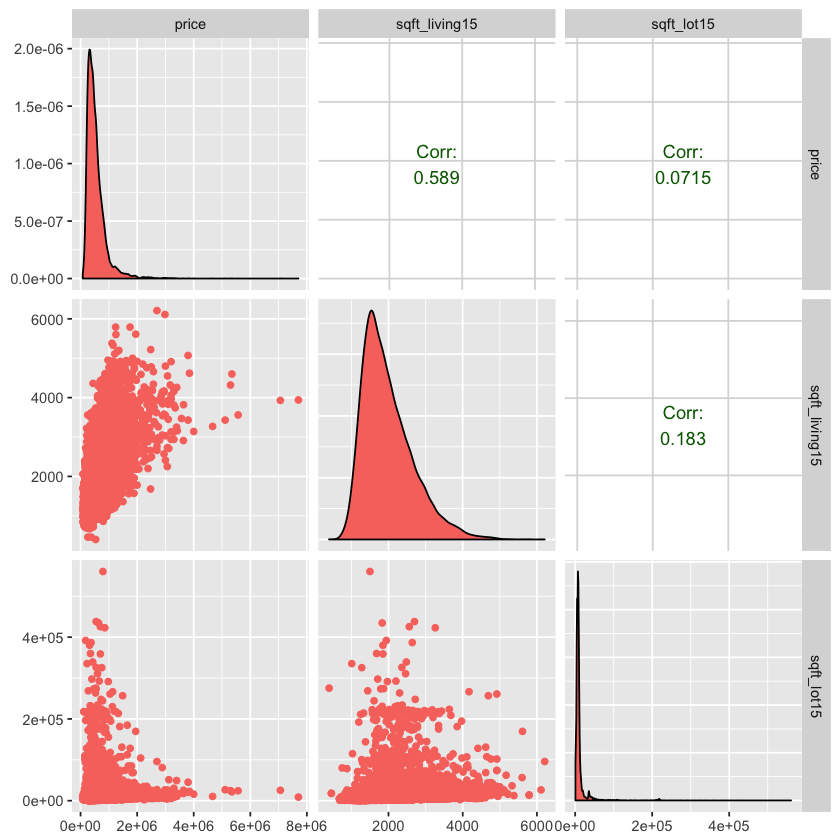

In [19]:
plot_g4

## (2) Corrplot을 활용하여 변수간의 상관관계 시각화
## 각 변수간의 상관관계를 1:1 로 검증한다. (id, date 제외)

In [20]:
corH <- cor(House2)

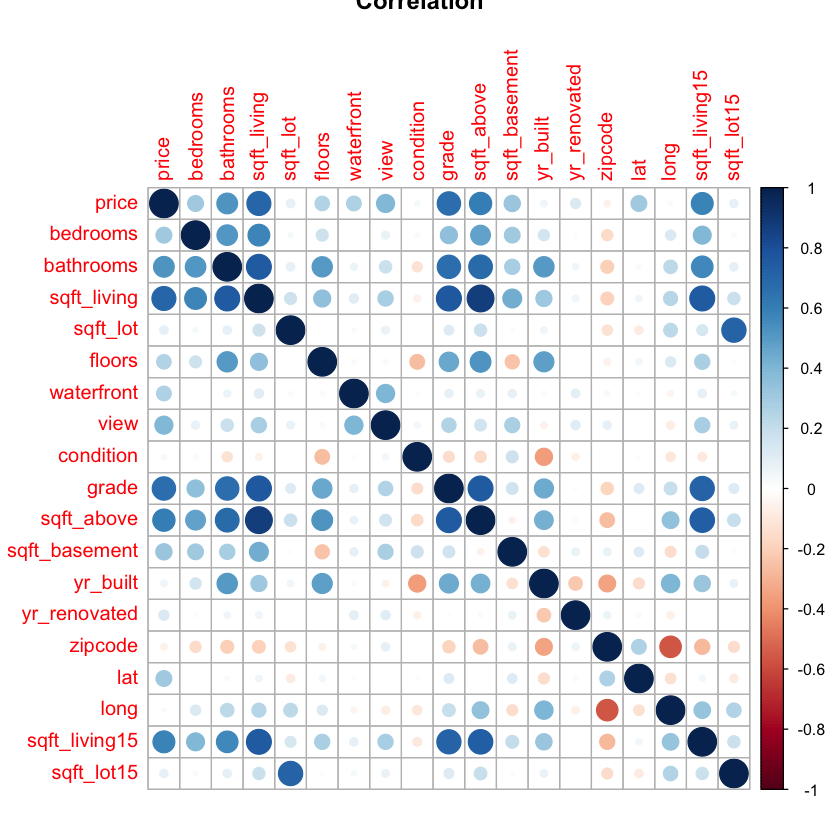

In [21]:
corrplot(corH, type="full", method = "circle", main="Correlation")

In [ ]:
print(round(corH, digits=3))

## corr_table : all variables

# corr between price vs sqft_living: <span style="color:gold">0.702</span>
# corr between price vs grade: <span style="color:silver">0.673</span>
# Corr between price vs sqft_above :<span style="color:brown">0.604</span>

###### Corr between price vs sqft_living15 : 0.587
###### corr between price vs bathrooms: 0.525
###### corr between price vs view: 0.401
###### corr between price vs sqft_basement : 0.321
###### corr between price vs lat: 0.312
###### corr between price vs bedrooms: 0.308
###### corr between price vs waterfront: 0.255
###### Corr between price vs floors : 0.256
###### Corr between price vs sqft_lot15 : 0.185
###### corr between price vs sqft_lot : 0.0897
###### corr between price vs yr_built : 0.0521
###### Corr between price vs condition : 0.0327
###### corr between price vs yr_renovated : 0.13
###### corr between price vs long : 0.0214
###### corr between price vs zipcode : -0.0527


## 위에 따라 , 데이터를 다음과 같이 분류/분석 가능하다.


## 추가적으로, 부동산의 크기를 기준으로 세 유형으로 구분 가능




##      sqft_living & sqft_lot 
##     sqft_above & sqft_basement 
##     sqft_living15 & sqft_lot15

##  이 중 sqft_living을 부동산 크기 측정의 주 기준으로 삼았다.



## $1단계
##  최종 모델에 대입 전, 상자그림을 통해 grade와 condition 두개의 범주형 데이터의 분포를 살펴본다.
##  (단, 결측치와 이상치가 발견된 경우에 한함)$

## $2단계
## floors, bedrooms, bathrooms, view, waterfron 에 대하여 1단계와 동일한 과정을 거친다.                        $

## $3단계 
## 연속형 변수에 대하여 상자그림을 그린다( sqft_v) 
##     (이상치에 대해선 필요시 대체한다.)$                                                  

## $4단계
## 면적당 부동산 가격과 가격의 각 분포를 비교하여 모델 설정에 유의한 값을 선정한다$

## $5단계
## 새로운 변수를 선정한다.
## 건축연도와 재건축연도를 포함한 최종건축연도 변수를 생성
## 가격과 최종건축연도의 상관관계를 분석하여 모델 선정유무를 
## 결정한다$

## $6단계
## 우편번호(Zipcode)와 가격의 상관관계는 극히 약함으로
## 변수에서 제외한다.$

## $7단계
## 범주형 변수들을 팩터 형태로 전환시킨다.$

## $8단계
## 독립 이표본검정을 다음 덤미 변수로 확인한다.
   ### (1) 지하공간의 유무를 기준으로 더미변수화
   ### (2) 수역근접성 유무를 기준으로 더미변수화$

## $9단계
 ### 독립 K 표본 검정; view를 ANOVA 로 검정한다.$

 ## $10단계
 ## 정제된 변수를 통해 가격 예측을 위한 
 ## 다중 선형 회귀 모형을 수립한다.$

## 10단계(H). 가격을 종속변수, 정제된 변수들을 독립변수로  가격을 예측하는 하는 다중 선형 회귀 모형을 수립
##          가격과 변수 간의 선행 요건과 상관관계를 분석한다.

## 11단계(H). 원데이터 "House"를 사용한다.
##              (*subset the data which house is sold in both 2014 and 2015*)
##              categorizing House$date in two ways by yrs(2014, 2015)
##              compare the difference of predicted price by using the different model
##              date:2014 ~ using sqft_living15, date:2015 ~using sqft_living15 instead of sqft_living

## 2. 일변량 데이터 분석

## 1단계. 순위형 데이터를 범주화한다.: grade, condition

## frequency

In [22]:
prettyR::freq(House2$grade)


Frequencies for House2$grade 
        7    8    9    6   10   11    5   12    4   13    3    1   NA
     8981 6068 2615 2038 1134  399  242   90   29   13    3    1    0
%    41.6 28.1 12.1  9.4  5.2  1.8  1.1  0.4  0.1  0.1    0    0    0 
%!NA 41.6 28.1 12.1  9.4  5.2  1.8  1.1  0.4  0.1  0.1    0    0 


In [23]:
prettyR::freq(House2$condition)


Frequencies for House2$condition 
        3    4    5    2    1   NA
     14031  5679  1701   172    30     0
%    64.9 26.3  7.9  0.8  0.1    0 
%!NA 64.9 26.3  7.9  0.8  0.1 


## graph

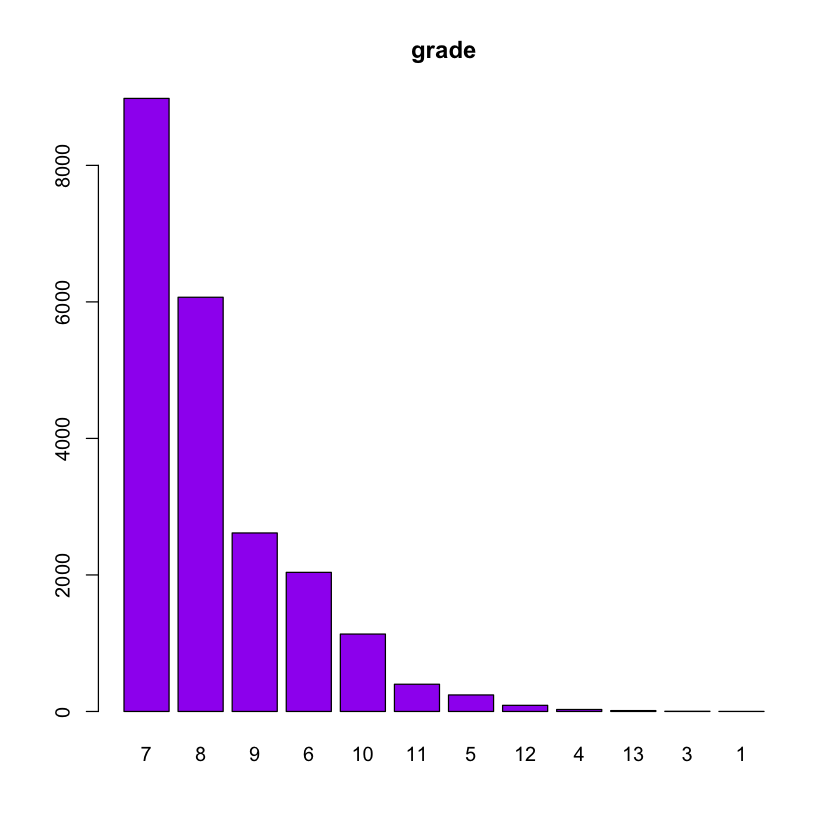

In [24]:
barplot(sort(table(House2$grade), decreasing = TRUE),
        col = "purple",
        main = "grade")

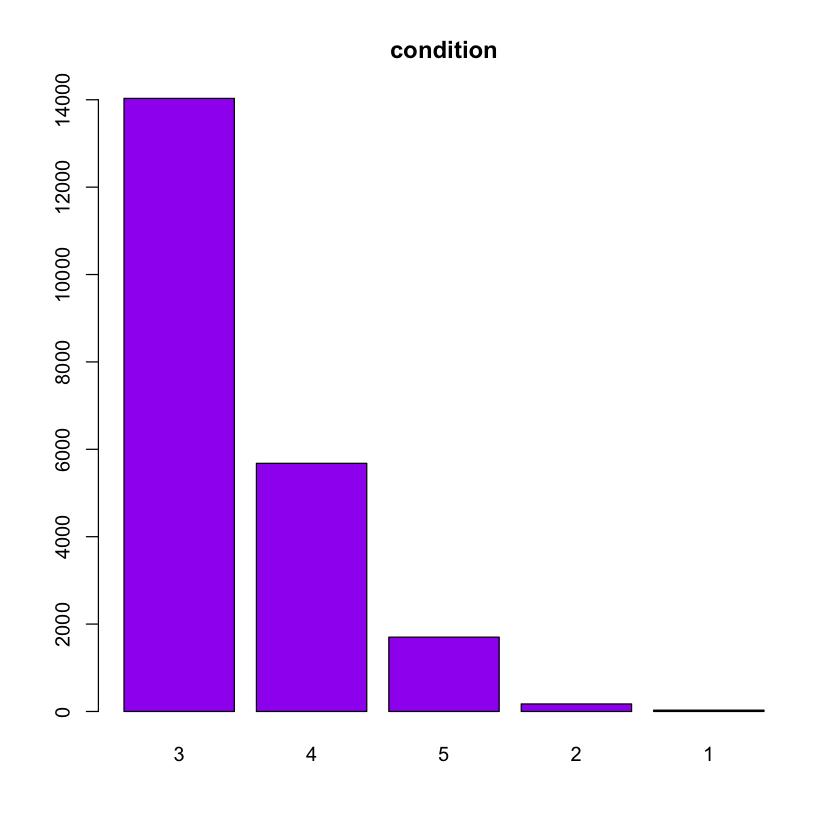

In [25]:
barplot(sort(table(House2$condition), decreasing = TRUE),
        col = "purple",
        main = "condition")

## 변수가 적기 때문에 이상치 분류가 필요 없음

## ST2-3. quantitative variables : all (only except grade & condition)

## summary, mean, median etc.

In [28]:
summary(House2)

     price            bedrooms        bathrooms      sqft_living   
 Min.   :  75000   Min.   : 0.000   Min.   :0.000   Min.   :  290  
 1st Qu.: 321950   1st Qu.: 3.000   1st Qu.:1.750   1st Qu.: 1427  
 Median : 450000   Median : 3.000   Median :2.250   Median : 1910  
 Mean   : 540088   Mean   : 3.371   Mean   :2.115   Mean   : 2080  
 3rd Qu.: 645000   3rd Qu.: 4.000   3rd Qu.:2.500   3rd Qu.: 2550  
 Max.   :7700000   Max.   :33.000   Max.   :8.000   Max.   :13540  
    sqft_lot           floors        waterfront            view       
 Min.   :    520   Min.   :1.000   Min.   :0.000000   Min.   :0.0000  
 1st Qu.:   5040   1st Qu.:1.000   1st Qu.:0.000000   1st Qu.:0.0000  
 Median :   7618   Median :1.500   Median :0.000000   Median :0.0000  
 Mean   :  15107   Mean   :1.494   Mean   :0.007542   Mean   :0.2343  
 3rd Qu.:  10688   3rd Qu.:2.000   3rd Qu.:0.000000   3rd Qu.:0.0000  
 Max.   :1651359   Max.   :3.500   Max.   :1.000000   Max.   :4.0000  
   condition         grade 

## gragh

## ST2. discrete variables : bedrooms, bathrooms, floors, waterfront, view

## (1) bedrooms

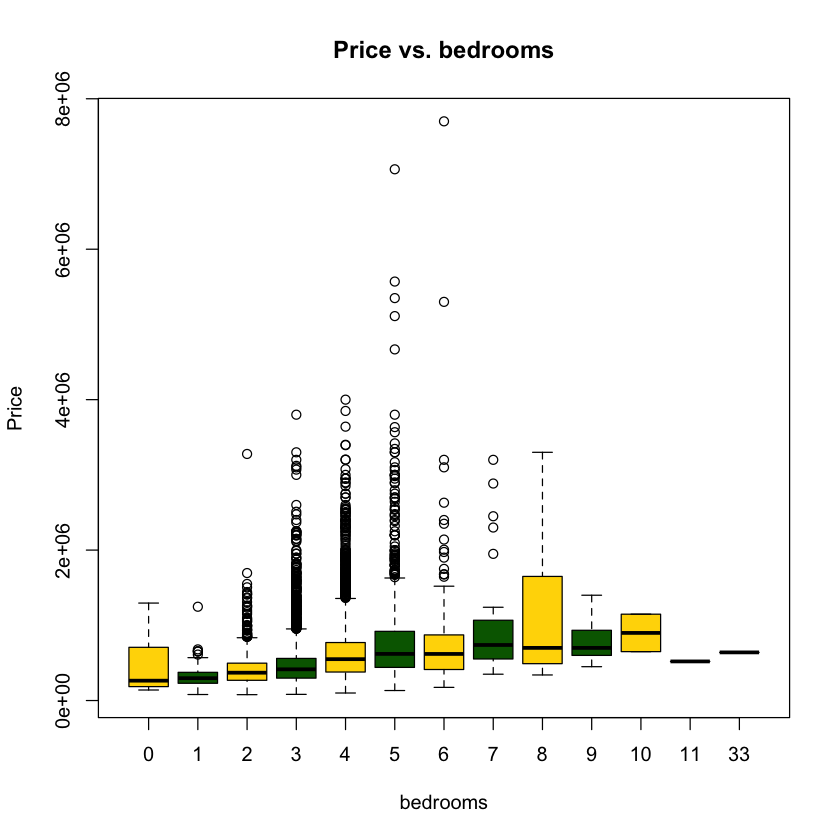

In [29]:
boxplot1=boxplot(price~bedrooms, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. bedrooms", xlab="bedrooms", ylab="Price")

## It seems that value 11, 33 is totally outlier.

## House2$bedrooms is discrete varible -> Can't use IQR accuately to locate outliers.

In [30]:
psych::describe(House2$bedrooms) 

vars n     mean     sd        median trimmed  mad    min max range skew    
X1 1    21613 3.370842 0.9300618 3      3.338037 1.4826 0   33  33    1.974026
   kurtosis se         
X1 49.04721 0.006326366

## skew 1.97 -> It has some extreme values in right side.

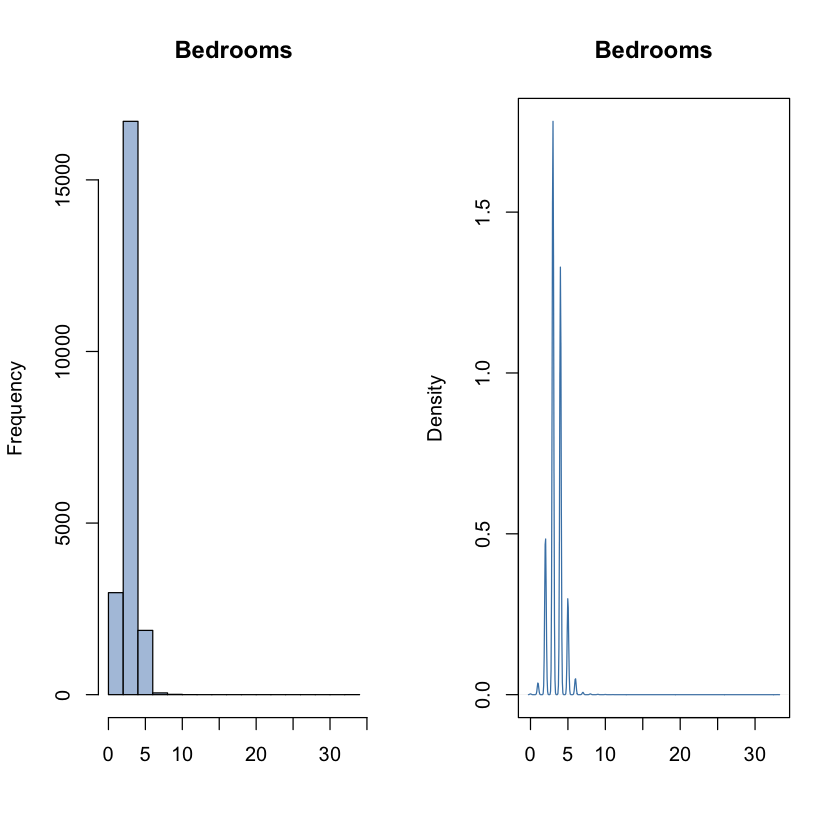

In [31]:
par(mfrow = c(1,2))
hist(House2$bedrooms, xlab = "", col = "lightsteelblue",  main = "Bedrooms")
plot(density(House2$bedrooms), xlab="", col = "steelblue", main="Bedrooms")

## Checking bedrooms extremes as distibution is very skewed

In [32]:
print(subset(House2, House2$bedrooms > 10))

       price bedrooms bathrooms sqft_living sqft_lot floors waterfront view
8758  520000       11      3.00        3000     4960      2          0    0
15871 640000       33      1.75        1620     6000      1          0    0
      condition grade sqft_above sqft_basement yr_built yr_renovated zipcode
8758          3     7       2400           600     1918         1999   98106
15871         5     7       1040           580     1947            0   98103
          lat     long sqft_living15 sqft_lot15
8758  47.5560 -122.363          1420       4960
15871 47.6878 -122.331          1330       4700


# There is one record each for bedroom 11 and 33. 
## 33 is extremly high value compared to mean(bedrooms) = 3.37
# 33 bedroom house has 1.75 bathrooms, sqft_living is also very less. Seems little odd.

# I suspect a data entry error here. Lets calculate the mean sqft_living of 3 bedroom house.


In [33]:
bed3 <- subset(House2,House2$bedrooms == 3)
bed3
print(tapply(bed3$sqft_living, bed3$bedrooms, mean))

price   bedrooms bathrooms sqft_living sqft_lot floors waterfront view
1      221900 3        1.00      1180         5650    1.0    0          0   
2      538000 3        2.25      2570         7242    2.0    0          0   
5      510000 3        2.00      1680         8080    1.0    0          0   
7      257500 3        2.25      1715         6819    2.0    0          0   
8      291850 3        1.50      1060         9711    1.0    0          0   
9      229500 3        1.00      1780         7470    1.0    0          0   
10     323000 3        2.50      1890         6560    2.0    0          0   
11     662500 3        2.50      3560         9796    1.0    0          0   
13     310000 3        1.00      1430        19901    1.5    0          0   
14     400000 3        1.75      1370         9680    1.0    0          0   
17     395000 3        2.00      1890        14040    2.0    0          0   
20     230000 3        1.00      1250         9774    1.0    0          0   
22    2000000 3        2.75      3050        44867    1.0    0          4   
25     329000 3        2.25      2450         6500    2.0    0          0   
26     233000 3        2.00      1710         4697    1.5    0          0   
27     937000 3        1.75      2450         2691    2.0    0          0   
28     667000 3        1.00      1400         1581    1.5    0          0   
29     438000 3        1.75      1520         6380    1.0    0          0   
31     580500 3        2.50      2320         3980    2.0    0          0   
34     535000 3        1.00      1090         3000    1.5    0          0   
36     696000 3        2.50      2300         3060    1.5    0          0   
44     685000 3        1.00      1570         2280    2.0    0          0   
45     309000 3        1.00      1280         9656    1.0    0          0   
46     488000 3        2.50      3160        13603    2.0    0          0   
47     210490 3        1.00       990         8528    1.0    0          0   
49     450000 3        1.75      1250         5963    1.0    0          0   
50    1350000 3        2.50      2753        65005    1.0    1          2   
51     228000 3        1.00      1190         9199    1.0    0          0   
53     600000 3        1.75      1410         4080    1.0    0          0   
58     301000 3        2.50      2420         4750    2.0    0          0   
⋮     ⋮       ⋮        ⋮         ⋮           ⋮        ⋮      ⋮          ⋮   
21545 589999  3        2.50      2140         3628    2      0          0   
21547 509900  3        2.50      3030         9053    2      0          0   
21550 327500  3        2.50      1820         1866    2      0          0   
21551 249000  3        2.00      1260         1125    2      0          0   
21554 465000  3        2.50      2050        15035    2      0          0   
21555 388000  3        2.50      2198         6222    2      0          2   
21556 549000  3        2.25      1230         1380    3      0          0   
21558 530000  3        2.50      1410         1250    2      0          0   
21559 747450  3        2.50      2110         1339    2      0          0   
21568 690000  3        3.25      1540         1428    3      0          0   
21571 330000  3        2.50      1450         5008    1      0          0   
21573 230000  3        1.75      1140         1201    2      0          0   
21575 610950  3        3.00      1680         1570    3      0          0   
21576 399950  3        2.50      3087         5002    2      0          0   
21580 645000  3        3.25      1730         1229    2      0          2   
21581 594866  3        3.00      2780         6000    2      0          0   
21582 625000  3        3.00      2780         6000    2      0          0   
21583 490000  3        2.25      1500         1290    2      0          0   
21585 380000  3        2.50      1260          900    2      0          0   
21586 270000  3        2.50      1870         5000    2      0          0   
21

       3 
1805.837 


# Mean sqft_living of 3 bedroom house is approx 1805 whereas for 33 bedrooms it is 1620.
# We can remove this, but I'm changing 33 bedrooms to 3. Not doing anything for 11 bedroom house.

In [34]:
House2[15871,2] <- 3 ## replace the outlier value

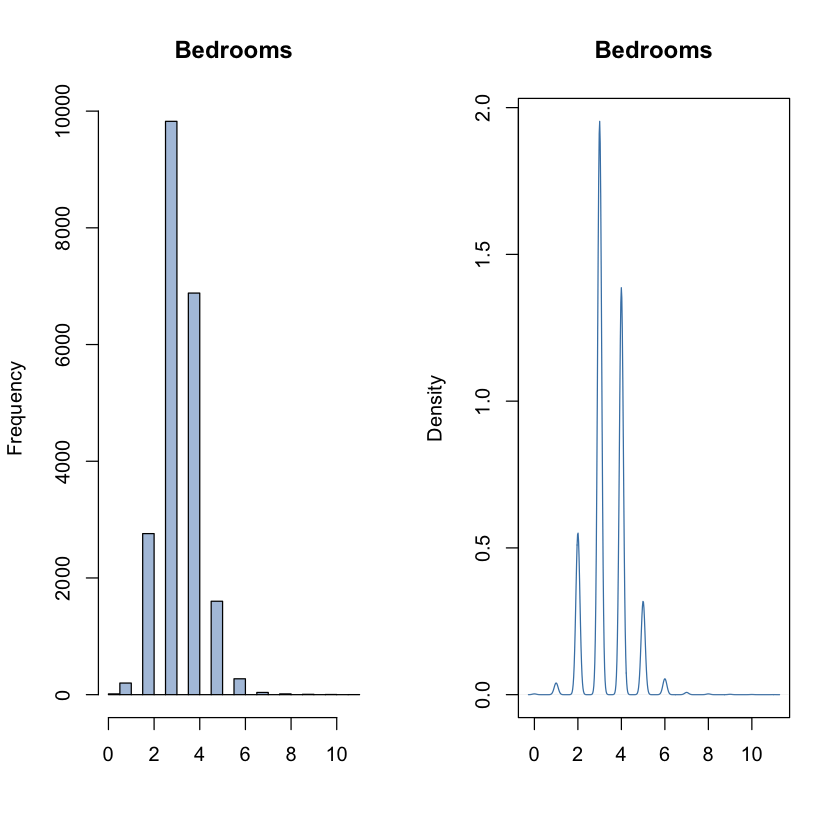

In [35]:
par(mfrow = c(1,2))
hist(House2$bedrooms, xlab = "", col = "lightsteelblue",  main = "Bedrooms")
plot(density(House2$bedrooms), xlab="", col = "steelblue", main="Bedrooms")

## Bedrooms finally seems having a linear relationship with price.

## (2) bathrooms

vars n     mean     sd        median trimmed  mad    min max range skew     
X1 1    21613 2.114757 0.7701632 2.25   2.074649 0.7413 0   8   8     0.5110366
   kurtosis se        
X1 1.278933 0.00523872

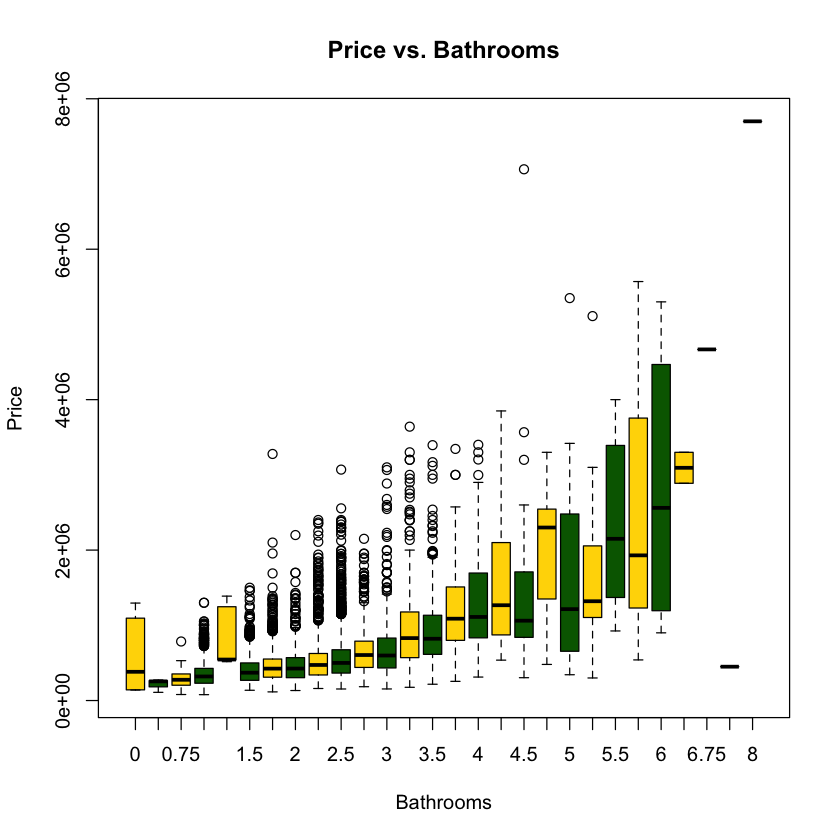

In [36]:
par(mfrow = c(1,1))

boxplot2=boxplot(price~bathrooms, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Bathrooms", xlab="Bathrooms", ylab="Price")

psych::describe(House2$bathrooms) 

## skew 1.28 -> It has some extreme values in right side.

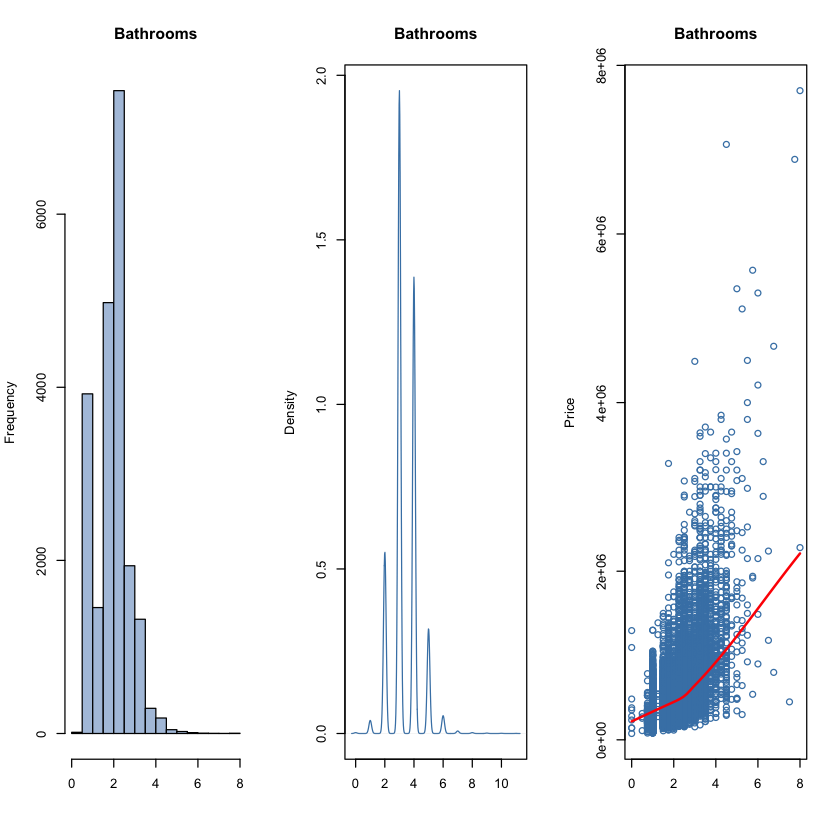

In [37]:
par(mfrow = c(1,3))
hist(House2$bathrooms, breaks = 20, xlab = "", col = "lightsteelblue",  main = "Bathrooms")
plot(density(House2$bedrooms), xlab="", col = "steelblue", main="Bathrooms")
scatter.smooth(House2$bathrooms, House2$price, col="steelblue", xlab="", ylab="Price",main="Bathrooms",lpars=list(col="red", lwd=2))

# Distribution looks skewed.
# Lets see what is the ratio of bedrooms >= 6

In [38]:
print(subset(House2, House2$bathrooms >6))
print(prop.table(table(House2$bathrooms >= 6))) ## FALSE 0.999

        price bedrooms bathrooms sqft_living sqft_lot floors waterfront view
4025   800000        7      6.75        7480    41664    2.0          0    2
7253  7700000        6      8.00       12050    27600    2.5          0    3
8093  4668000        5      6.75        9640    13068    1.0          1    4
8547   450000        9      7.50        4050     6504    2.0          0    0
9255  6885000        6      7.75        9890    31374    2.0          0    4
12778 2280000        7      8.00       13540   307752    3.0          0    4
14557 2888000        5      6.25        8670    64033    2.0          0    4
18303 3300000        5      6.25        8020    21738    2.0          0    0
20579 1180000        6      6.50        6260    10955    2.0          0    0
21507 2238890        5      6.50        7270   130017    2.0          0    0
      condition grade sqft_above sqft_basement yr_built yr_renovated zipcode
4025          3    11       5080          2400     1953            0   98166

## replace the value(>=6) according to their sqft_living values
## only if they are odd compared to other data which has similar sqft_living

In [39]:
bath4 <- subset(House2,House2$bathrooms == 4)
bath5 <- subset(House2,House2$bathrooms == 5)
bath6 <- subset(House2,House2$bathrooms == 6)
bath6.25 <- subset(House2,House2$bathrooms == 6.25)

In [40]:
mean(bath4$sqft_living) ## 4071.868
mean(bath5$sqft_living) ## 4851.857
mean(bath6$sqft_living) ## 6443.333
mean(bath6.25$sqft_living) ## 8345

[1] 4071.868

[1] 4851.857

[1] 6443.333

[1] 8345

In [41]:
House2[8547,3] <- 4 ## 9, 4050 
House2[20579,3] <- 5.75 ## 6, 6260

In [42]:
psych::describe(House2$bathrooms) ## skew 0.49
print(subset(House2, House2$bathrooms >6))

vars n     mean     sd        median trimmed  mad    min max range skew     
X1 1    21613 2.114561 0.7692174 2.25   2.074649 0.7413 0   8   8     0.4948063
   kurtosis se         
X1 1.165246 0.005232288

        price bedrooms bathrooms sqft_living sqft_lot floors waterfront view
4025   800000        7      6.75        7480    41664    2.0          0    2
7253  7700000        6      8.00       12050    27600    2.5          0    3
8093  4668000        5      6.75        9640    13068    1.0          1    4
9255  6885000        6      7.75        9890    31374    2.0          0    4
12778 2280000        7      8.00       13540   307752    3.0          0    4
14557 2888000        5      6.25        8670    64033    2.0          0    4
18303 3300000        5      6.25        8020    21738    2.0          0    0
21507 2238890        5      6.50        7270   130017    2.0          0    0
      condition grade sqft_above sqft_basement yr_built yr_renovated zipcode
4025          3    11       5080          2400     1953            0   98166
7253          4    13       8570          3480     1910         1987   98102
8093          3    12       4820          4820     1983         2009   98040

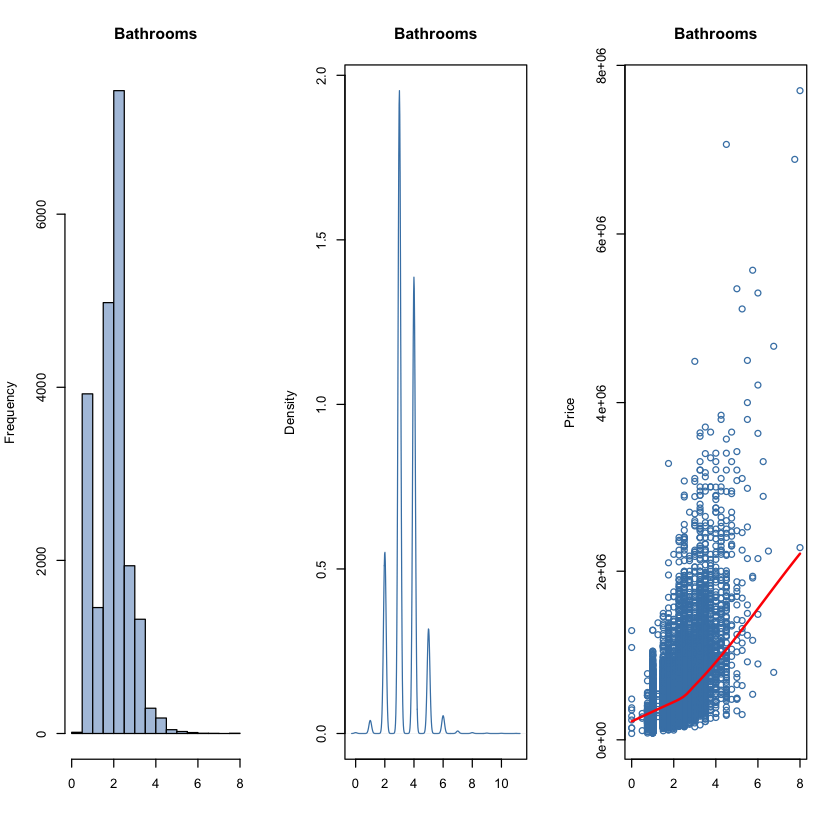

In [43]:
par(mfrow = c(1,3))
hist(House2$bathrooms, breaks = 20, xlab = "", col = "lightsteelblue",  main = "Bathrooms")
plot(density(House2$bedrooms), xlab="", col = "steelblue", main="Bathrooms")
scatter.smooth(House2$bathrooms, House2$price, col="steelblue", xlab="", ylab="Price",main="Bathrooms",lpars=list(col="red", lwd=2))

vars n     mean     sd        median trimmed  mad    min max range skew     
X1 1    21613 1.494309 0.5399889 1.5    1.452085 0.7413 1   3.5 2.5   0.6160912
   kurtosis   se         
X1 -0.4851211 0.003673054

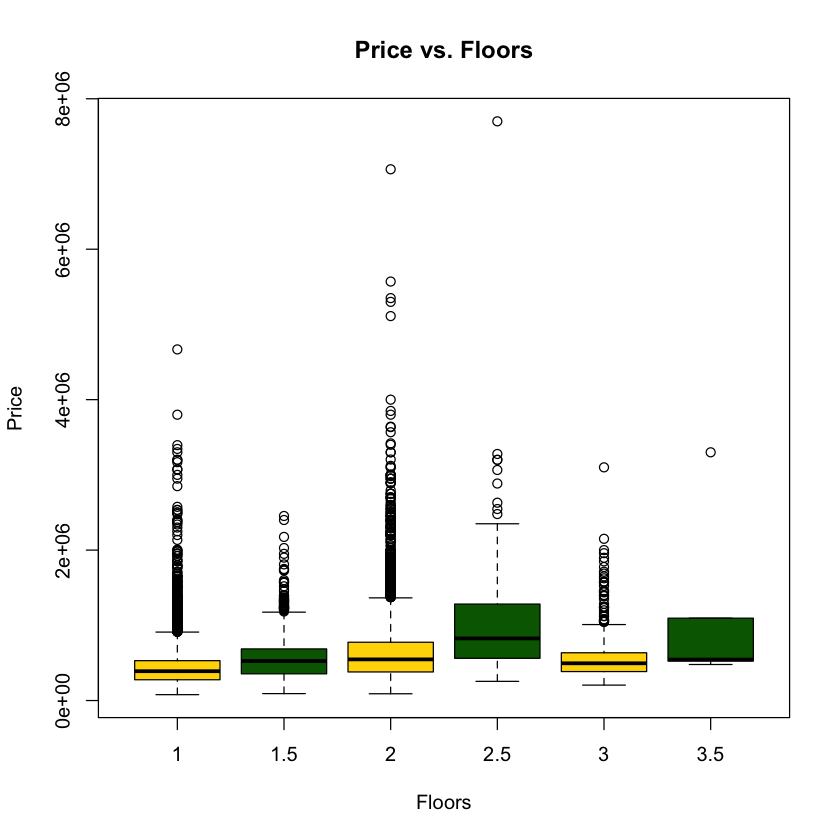

In [44]:
## (3) floors
par(mfrow = c(1,1))
boxplot3=boxplot(price~floors, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Floors", xlab="Floors", ylab="Price")

psych::describe(House2$floors) # skew 0.62

vars n     mean      sd        median trimmed mad min max range skew    
X1 1    21613 0.2343034 0.7663176 0      0       0   0   4   4     3.395278
   kurtosis se         
X1 10.88894 0.005212562

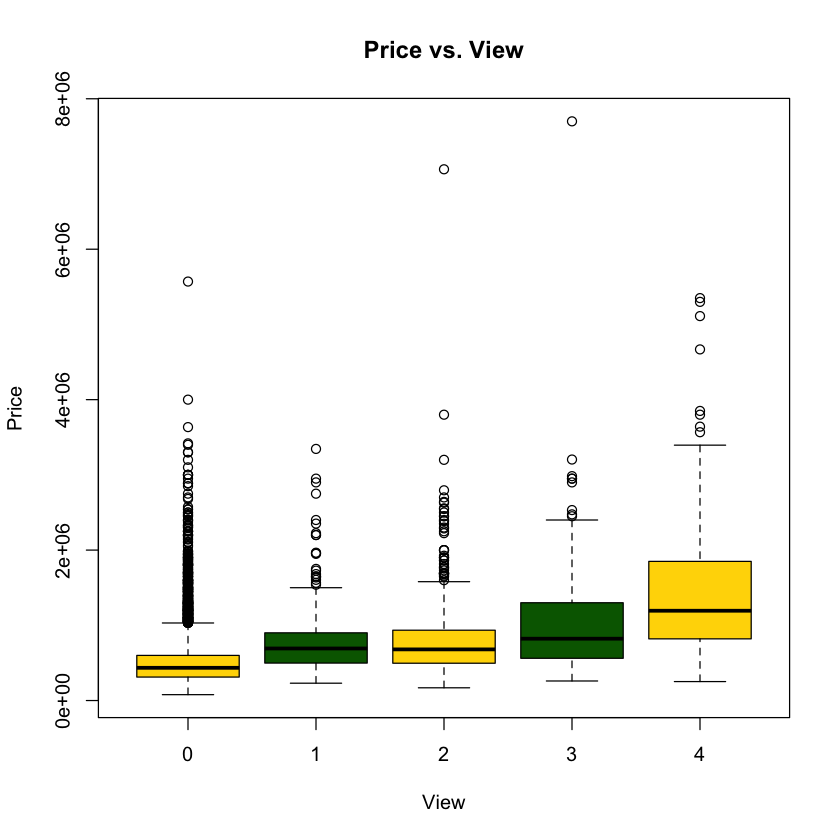

In [45]:
## (4) view

boxplot4=boxplot(price~view, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. View", xlab="View", ylab="Price")

psych::describe(House2$view) # skew 3.4

## No proper way to replace the values even if skew is really high. 
## even though skew is over 2, it has only few numbers of values

vars n     mean        sd        median trimmed mad min max range skew    
X1 1    21613 0.007541757 0.0865172 0      0       0   0   1   1     11.38353
   kurtosis se          
X1 127.5906 0.0005884979

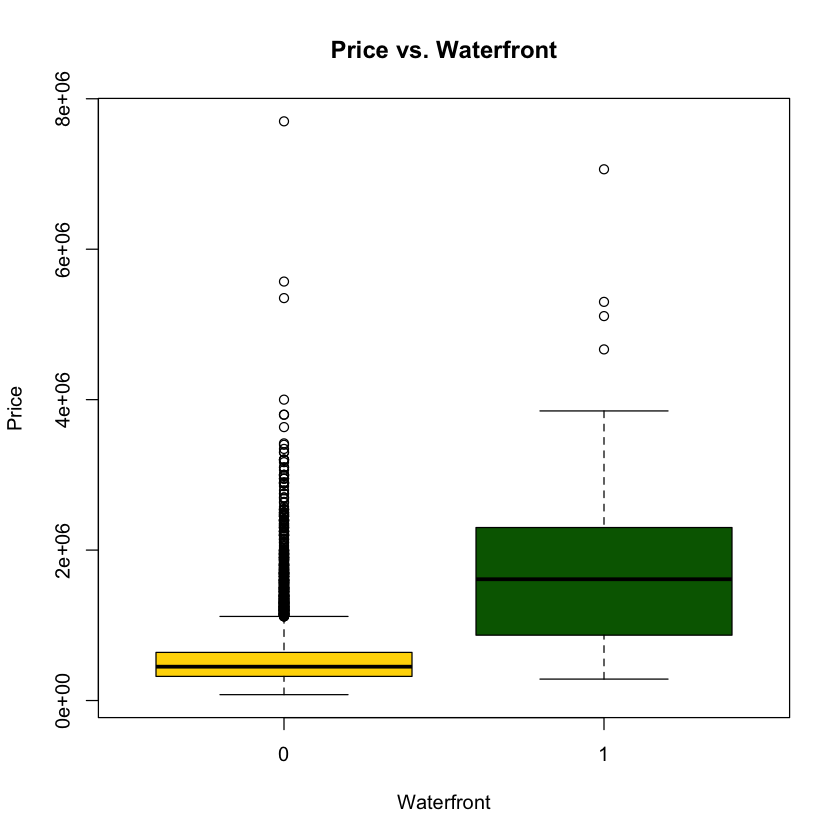

In [46]:
## (5) waterfront

boxplot5=boxplot(price~waterfront, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Waterfront", xlab="Waterfront", ylab="Price")

psych::describe(House2$waterfront) # 11.38 -> it's okay. this is kind of dummy_var

## ST3. Continuous variables : sqft_v

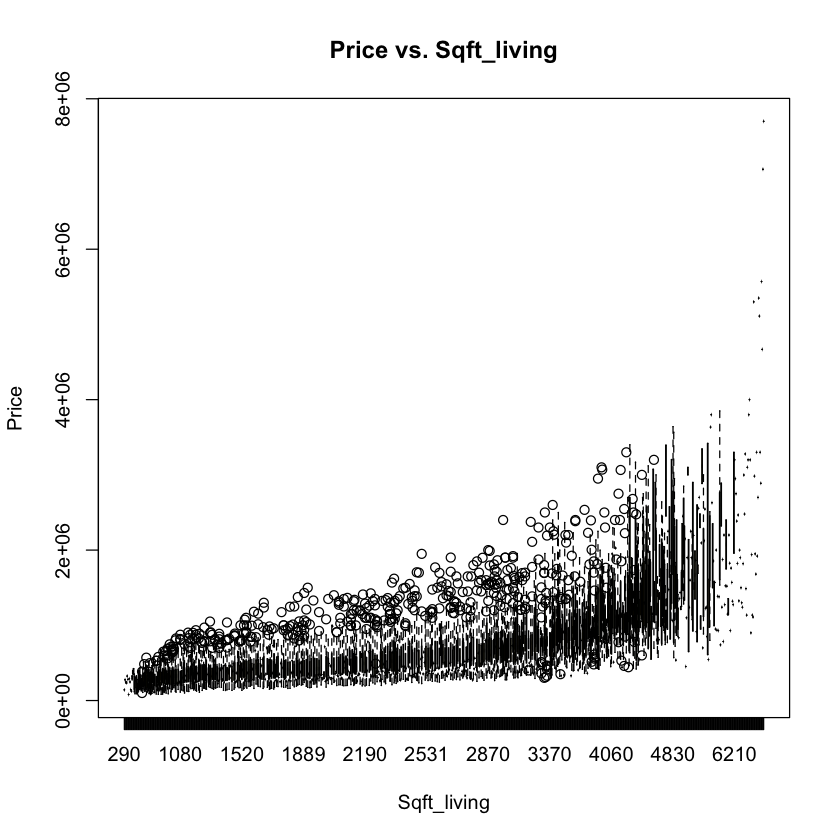

In [47]:
boxplot6=boxplot(price~sqft_living, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Sqft_living", xlab="Sqft_living", ylab="Price")

In [48]:
psych::describe(House2$sqft_living) ## skew 1.47

vars n     mean   sd       median trimmed  mad     min max   range skew    
X1 1    21613 2079.9 918.4409 1910   1984.399 800.604 290 13540 13250 1.471351
   kurtosis se      
X1 5.24084  6.247319

In [49]:
psych::describe(log(House2$sqft_living)) ## skew - 0.06 (Change the scale with log())

vars n     mean     sd        median   trimmed  mad       min      max     
X1 1    21613 7.550335 0.4248069 7.554859 7.552942 0.4291071 5.669881 9.513404
   range    skew        kurtosis   se         
X1 3.843523 -0.03543277 -0.0552155 0.002889575

In [50]:
cor.test(House2$price, House2$sqft_living) # 0.702


	Pearson's product-moment correlation

data:  House2$price and House2$sqft_living
t = 144.92, df = 21611, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6952099 0.7087336
sample estimates:
      cor 
0.7020351 


In [51]:
cor.test(House2$price, log(House2$sqft_living)) # 0.612 (Change the scale with log())


	Pearson's product-moment correlation

data:  House2$price and log(House2$sqft_living)
t = 113.67, df = 21611, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6032917 0.6199796
sample estimates:
      cor 
0.6117037 


## I will go with original sqft_living.

In [52]:
distIQR <- IQR(House2$sqft_living, na.rm = TRUE)
posIQR <- quantile(House2$sqft_living, probs = c(0.25,0.75), na.rm=TRUE)

In [53]:
posIQR

25%  75% 
1427 2550

In [54]:
Down_lim <- posIQR[[1]] - distIQR*1.5

In [55]:
Up_lim <- posIQR[[3]] + distIQR*1.5

ERROR: Error in posIQR[[3]]: 첨자의 허용 범위를 벗어났습니다


In [56]:
print(prop.table(table(House2$sqft_living > 3673))) # 0.057 ## top 5%
print(prop.table(table(House2$sqft_living >= 4980))) ## 0.010 ## top 1%
print(prop.table(table(House2$sqft_living >= 5586))) ## 0.005 ## top 0.5%
print(prop.table(table(House2$sqft_living > 296))) ## 0.9995 ~= 1


     FALSE       TRUE 
0.94308981 0.05691019 

     FALSE       TRUE 
0.98995975 0.01004025 

      FALSE        TRUE 
0.995003007 0.004996993 

       FALSE         TRUE 
4.626845e-05 9.999537e-01 


## We can replace the outliers. However, in itself, it has high corr_value with price. 
## It almost seems price and sqft_living have a linear realationship

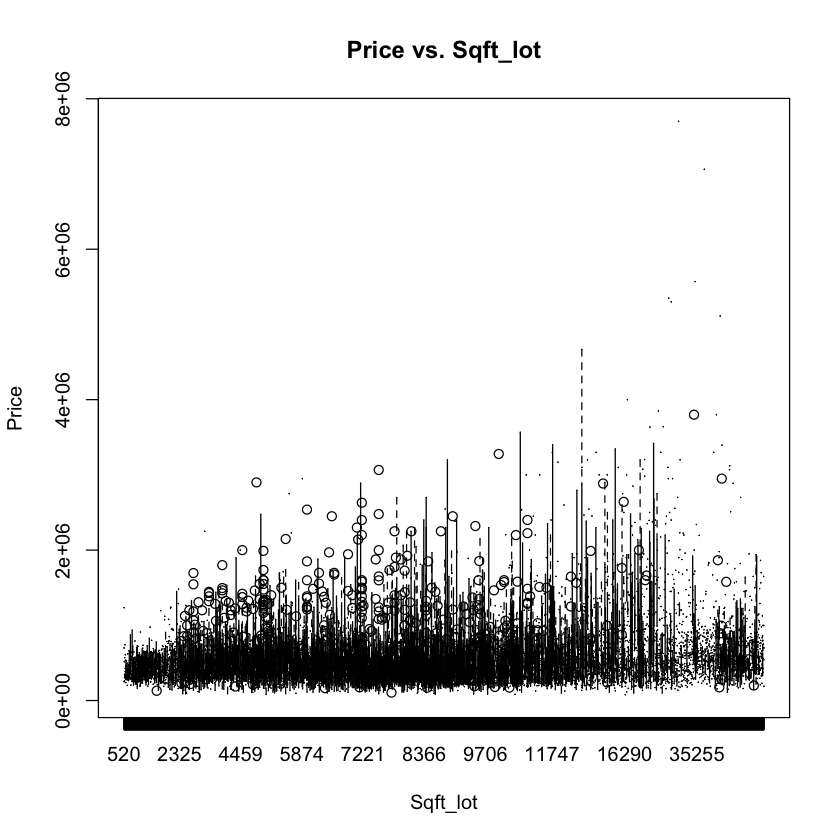

In [57]:
## (2) sqft_lot

boxplot7=boxplot(price~sqft_lot, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Sqft_lot", xlab="Sqft_lot", ylab="Price")

In [58]:
psych::describe(House2$sqft_lot) # skew 13.06
## Skew is really high, but cor(price, sqft_lot) is extremely low.

vars n     mean     sd       median trimmed  mad      min max     range  
X1 1    21613 15106.97 41420.51 7618   8259.527 3881.447 520 1651359 1650839
   skew     kurtosis se      
X1 13.05821 284.9849 281.7461

vars n     mean     sd      median trimmed  mad    min max  range skew    
X1 1    21613 1788.391 828.091 1560   1682.944 667.17 290 9410 9120  1.446464
   kurtosis se      
X1 3.400647 5.632751

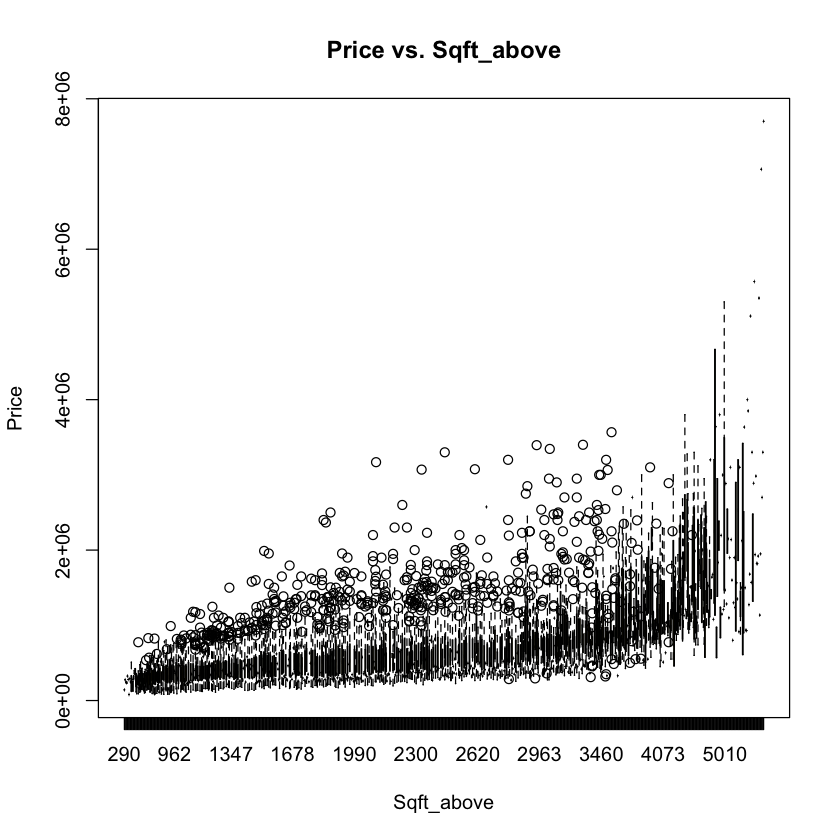

In [59]:
## (3) sqft_above

boxplot8=boxplot(price~sqft_above, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Sqft_above", xlab="Sqft_above", ylab="Price")

psych::describe(House2$sqft_above) # skew 1.46

vars n     mean     sd      median trimmed  mad    min max  range skew    
X1 1    21613 1788.391 828.091 1560   1682.944 667.17 290 9410 9120  1.446464
   kurtosis se      
X1 3.400647 5.632751

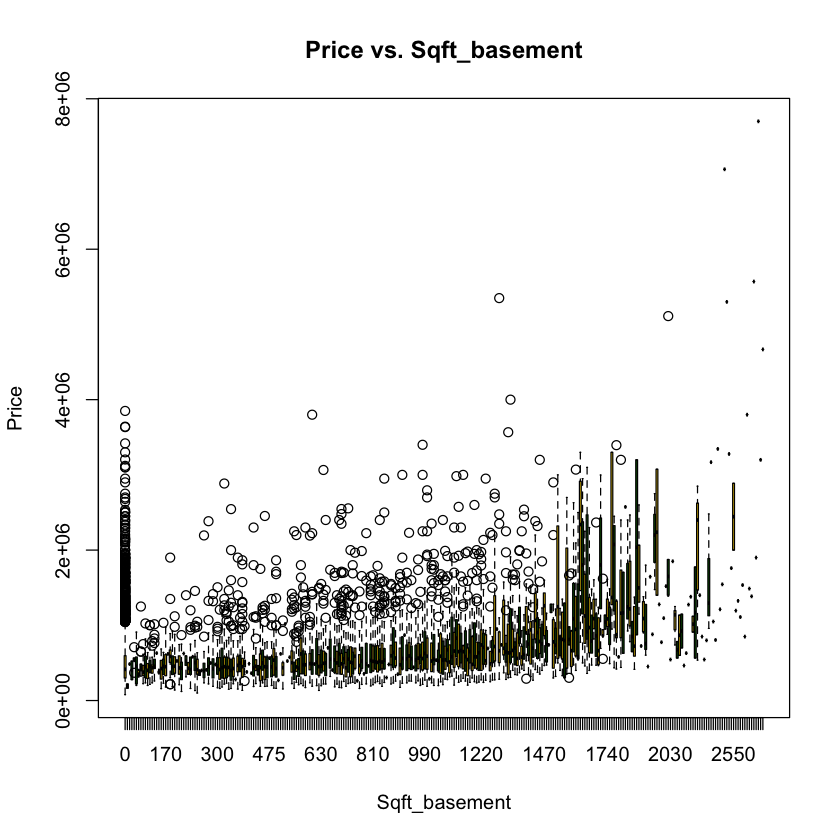

In [60]:
## (4) sqft_basement

boxplot9=boxplot(price~sqft_basement, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Sqft_basement", xlab="Sqft_basement", ylab="Price")

psych::describe(House2$sqft_above) # skew 1.45

vars n     mean     sd       median trimmed  mad     min max  range skew    
X1 1    21613 1986.552 685.3913 1840   1914.071 607.866 399 6210 5811  1.108027
   kurtosis se      
X1 1.596023 4.662094

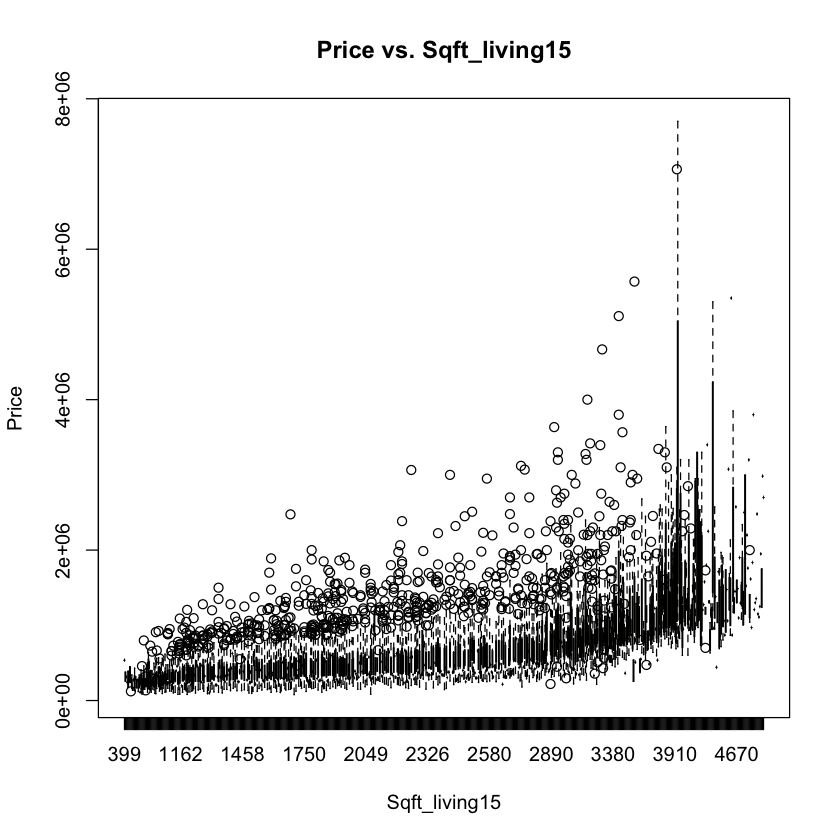

In [61]:
## (5) sqft_living15

boxplot10=boxplot(price~sqft_living15, data=Training, 
                 col=(c("gold","darkgreen")),
                 main="Price vs. Sqft_living15", xlab="Sqft_living15", ylab="Price")

psych::describe(House2$sqft_living15) # skew 1.11

vars n     mean     sd       median trimmed  mad      min max    range 
X1 1    21613 12768.46 27304.18 7620   7903.213 3713.913 651 871200 870549
   skew     kurtosis se      
X1 9.505424 150.7137 185.7255

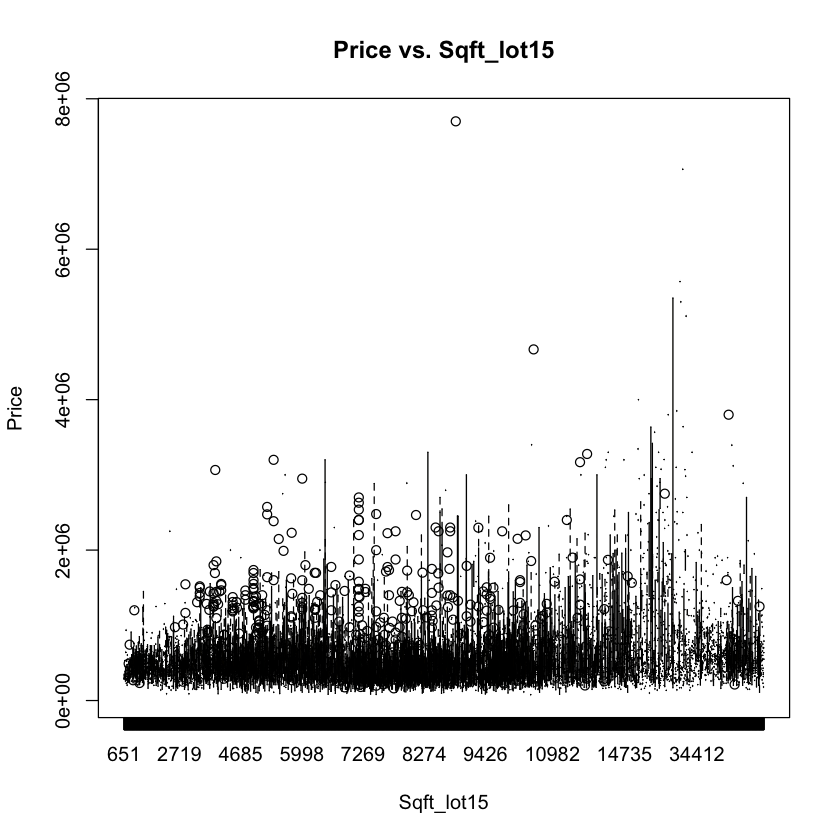

In [62]:
## (6) sqft_lot15

boxplot11=boxplot(price~sqft_lot15, data=Training, 
                  col=(c("gold","darkgreen")),
                  main="Price vs. Sqft_lot15", xlab="Sqft_lot15", ylab="Price")

psych::describe(House2$sqft_lot15) # skew 9.51

$breaks
 [1]       0  500000 1000000 1500000 2000000 2500000 3000000 3500000 4000000
[10] 4500000 5000000 5500000 6000000 6500000 7000000 7500000 8000000

$counts
 [1] 12560  7588   949   318   101    52    23    11     3     1     3     1
[13]     0     1     1     1

$density
 [1] 1.162263e-06 7.021700e-07 8.781752e-08 2.942673e-08 9.346227e-09
 [6] 4.811919e-09 2.128349e-09 1.017906e-09 2.776107e-10 9.253690e-11
[11] 2.776107e-10 9.253690e-11 0.000000e+00 9.253690e-11 9.253690e-11
[16] 9.253690e-11

$mids
 [1]  250000  750000 1250000 1750000 2250000 2750000 3250000 3750000 4250000
[10] 4750000 5250000 5750000 6250000 6750000 7250000 7750000

$xname
[1] "House2$price"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

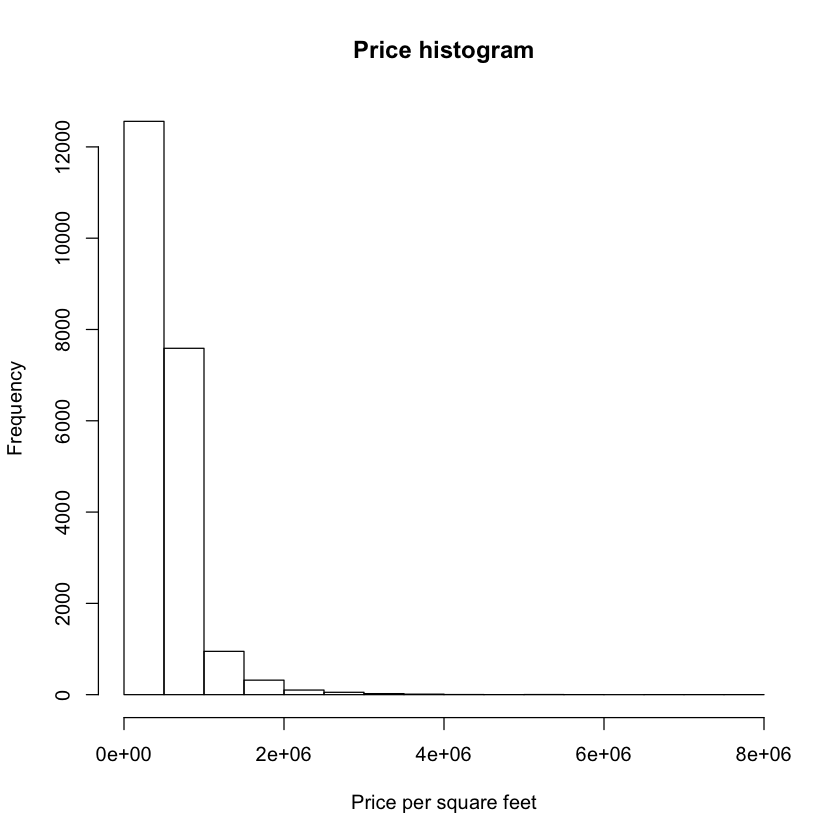

In [63]:
## ST4. Compare distribution of price and price/sqft_living 

hist_price <- hist(House2$price, main = "Price histogram",  xlab = "Price per square feet")
hist_price

## maybe we should think about using price/sqft (*reduce the scale to get better dist)

In [64]:
House2$price_per_sqft<- House2$price/House2$sqft_living

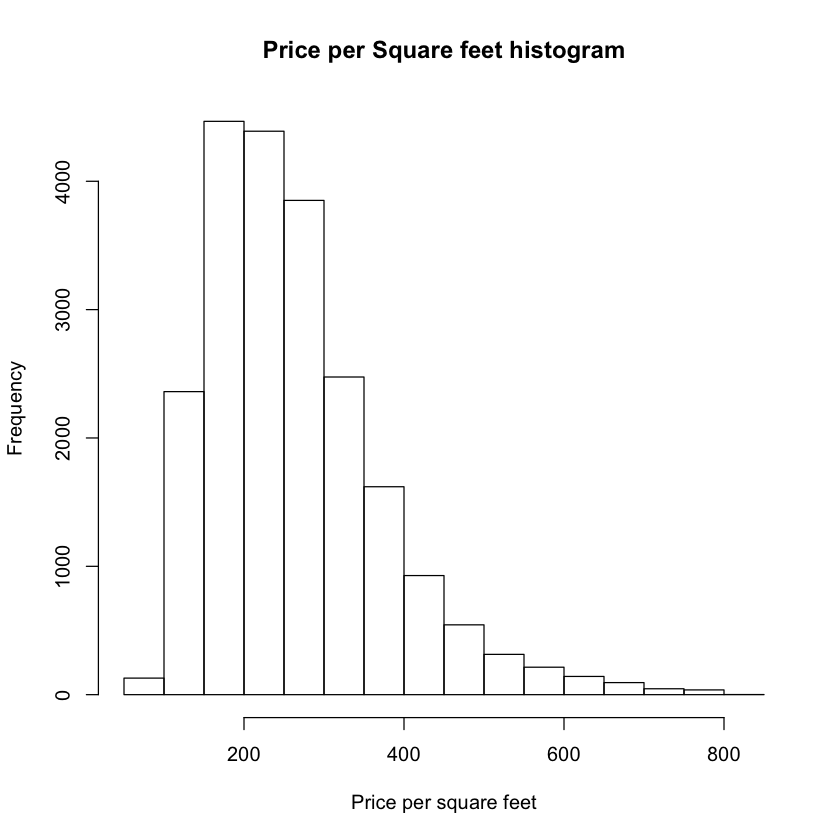

In [65]:
hist_pricesq <- hist(House2$price_per_sqft, main = "Price per Square feet histogram", xlab = "Price per square feet")

## Better distribution than price ~ it seems more closer to bell-shape(ND).
## I will use price_per_sqft instead of price

## visualization Corr in all var _ Corrplot including new variable.

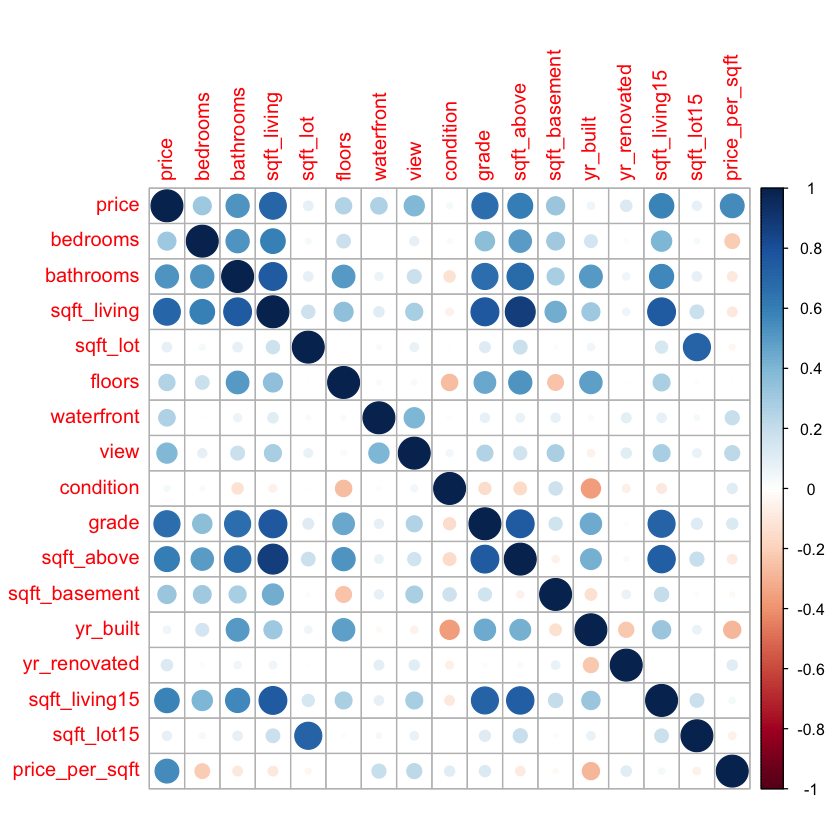

In [66]:
H_numeric <- House2[,c(1:14, 18:20)]
corrplot(cor(H_numeric), method = "circle")

## Price has the highest positively correlations with sqft_living, grade, sqft_above and sqft_living15.
## Price_per_sqft has low correlation with most variables.


## Thus, I will use original price as a dependent valiable in model.

## ST5. (1) make new variable:yr_built_final by including both yr_built and yr_renovated. 
##      (2) get cor(price, yr_built_final) and decide whether I put this one in model or not.

In [67]:
for(i in 1:21613){
  if(House2$yr_renovated[i] !=0){
    House2$yr_built[i] <-House2$yr_renovated[i]
  }
}

cor(House2$price, House2$yr_built) # 0.054

[1] 0.1057546

## ST6.  location variables ~ land : lat, long -> Clustering

## Quick look at the land distributtion

NULL

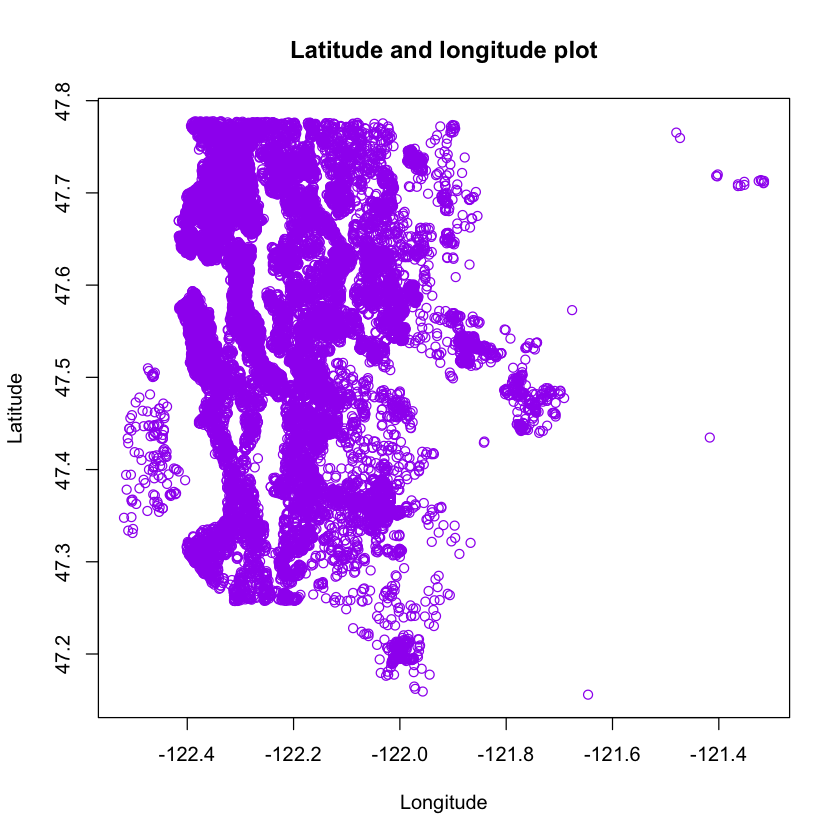

In [68]:
par(mfrow=c(1,1))
plot_loc <- plot(House2$long, House2$lat, main = "Latitude and longitude plot",xlab = "Longitude",ylab = "Latitude", col = "purple")
plot_loc

In [69]:
## Clustering

## set the number of clusters.
nc <- NbClust(House2, min.nc=2, max.nc=40, method="Kmeans")

ERROR: Error in NbClust(House2, min.nc = 2, max.nc = 40, method = "Kmeans"): invalid clustering method


## TSS matrix is indefinite. There must be too many missing values. The index cannot be calculated.
## Just let's start with 20 clusters.

## In clustering, I will use price_per_sqft instead of price
## Just because, I need three variable which I use in this process are independent from each other.

In [71]:
House_clustering20 <- kmeans(scale(House2[,c(1,16,17)]), center=20, iter.max=100, trace=FALSE)
House_clustering20

K-means clustering with 20 clusters of sizes 854, 524, 1638, 1779, 1506, 617, 678, 2854, 266, 902, 66, 1163, 266, 1037, 693, 1317, 1269, 1711, 1184, 1289

Cluster means:
         price         lat         long
1  -0.71967239 -1.86571108 -0.845968787
2   0.29003579 -0.02670555 -1.235821615
3   0.07816854  0.54095168  1.463854514
4  -0.13152264  1.18103834  0.262853760
5  -0.51083227 -0.62626608  0.392484198
6  -0.18154286 -0.30212485  2.825952461
7   2.28884213  0.44925813 -0.389658648
8  -0.29996190  1.08382165 -0.863465688
9   4.27489189  0.39318060 -0.008263574
10 -0.15468456  0.16221398 -0.569771378
11  8.34210226  0.47377109 -0.199451638
12 -0.56403744 -0.24546124 -1.091920929
13  0.09211032 -1.08288099 -1.183987048
14 -0.77287168 -0.41032800 -0.489207900
15 -0.74837940 -1.33649947 -0.595454298
16  0.20995524  0.10730233  0.533472102
17 -0.50147265 -1.61096803  1.282608929
18  0.60239252  0.75444469 -0.877355683
19  1.13819350  0.47731493  0.676957123
20 -0.66789807 -1.51903471  0.

In [72]:
House2$cluster<-factor(House_clustering20$cluster)

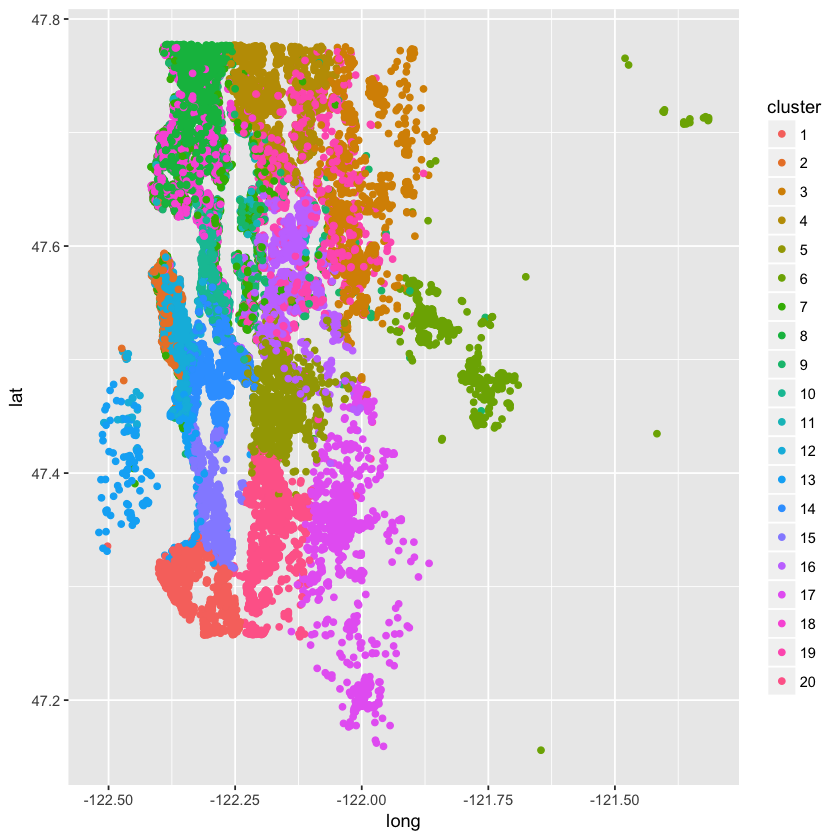

In [73]:
## plotting the clusters

ggplot(data= House2, aes(x = long, y = lat)) + geom_point(aes(color=cluster))

In [74]:
## Use ggmap() to bring googlemap of king county

getmap_king <- get_googlemap("king county", zoom = 10)
getmap_king <- ggmap(getmap_king)

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=king+county&zoom=10&size=640x640&scale=2&maptype=terrain&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=king%20county&sensor=false


Warning message:
“Removed 338 rows containing missing values (geom_point).”

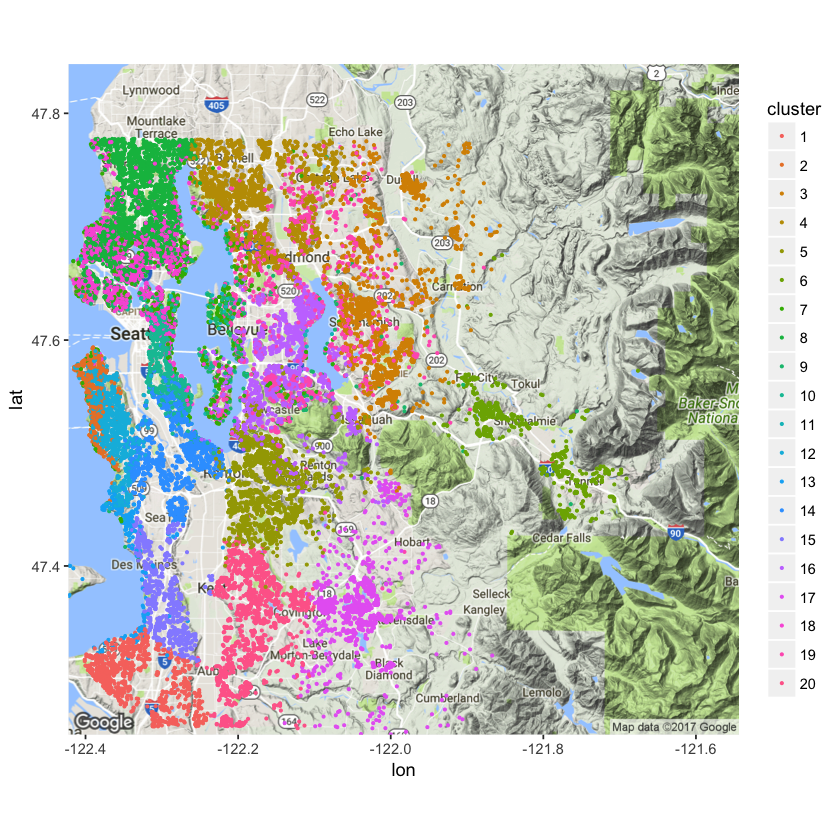

In [75]:
## plotting the clusters on ggmap

map_cluster <- getmap_king + geom_point(data=House2, aes(x=long, y=lat, colour=cluster),size=0.5)
map_cluster

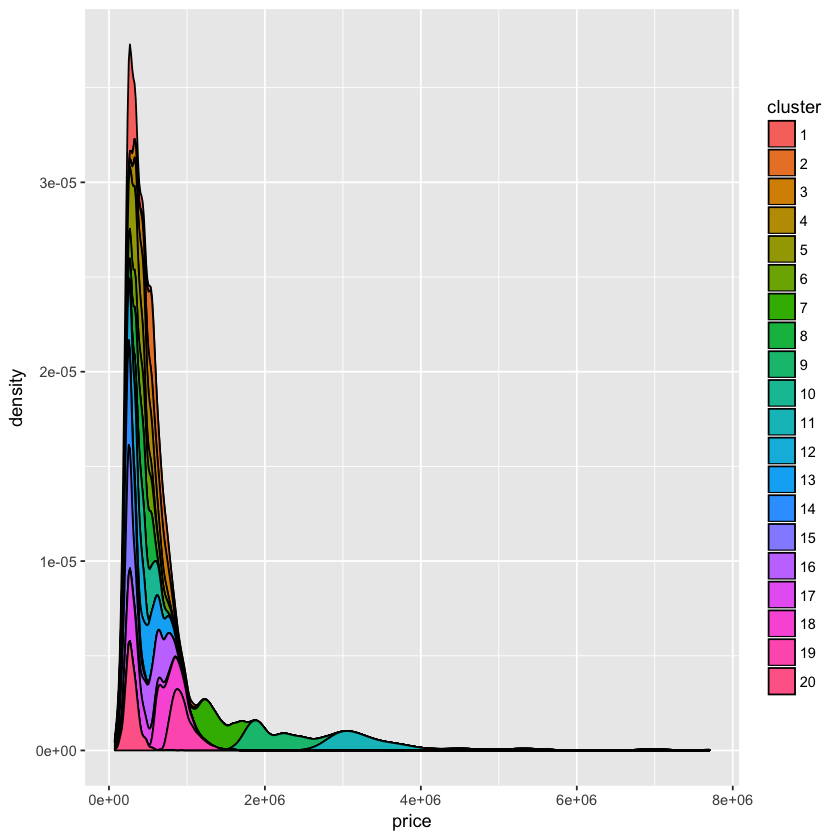

In [76]:
## density_plot

ggplot(House2, aes(price, fill = cluster)) + geom_density(position = "stack")

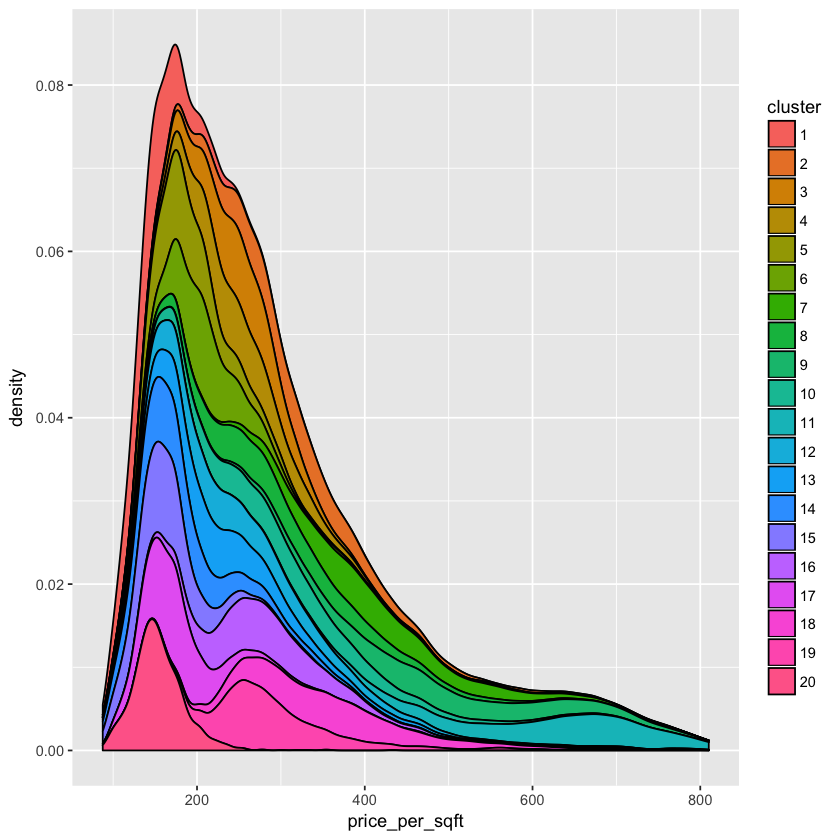

In [77]:
## It's too narrow, so I will use price_per_sqft as x-axis
ggplot(House2, aes(price_per_sqft, fill = cluster)) + geom_density(position = "stack")


## The latitude and longitude plotting shows the clusters location, looks good, the density plot shows that most clusters have a similar price per square feet.

# Creating dummy variables for the clusters

In [78]:
dummies <- data.frame(matrix(nrow = nrow(House2),ncol = 20))

In [79]:
for(i in 1:20){
  dummies[,i] <- ifelse(House2$cluster == i, 1,0)
}

nrow(House2)
sum(dummies) == nrow(House2)

kc <- cbind(House2,dummies)


[1] 21613

[1] TRUE

In [80]:
str(House2$grade)
str(House2$condition)

 num [1:21613] 7 7 6 7 8 11 7 7 7 7 ...
 num [1:21613] 3 3 3 5 3 3 3 3 3 3 ...


In [137]:
House2$grade <- as.factor(House2$grade)
House2$condition <- as.factor(House2$condition)

## ST8. independent two sample test

## (1) dummy variable : exist_base 

## I wanna test the significance of existence of basement.



# exist_basement <- as.data.frame(House2$sqft_basement)

In [82]:
House2$exist_base <- House2$sqft_basement

In [83]:
for(i in 1:21613){
  if(House2$exist_base[i] != "0"){
    House2$exist_base[i] = "1"
  }
}

## H0 : There is no difference of mean(price_per_sqft) depends on the existence of basement.
## H1 : not H0

# 1) test of normality

## H0 : No observable difference between (both) data_set and normal distribution
## H1 : not H0

## n > 5,000 : we can't use shapiro normality test

In [84]:
by(House2$price, House2$exist_base, ad.test)

House2$exist_base: 0

	Anderson-Darling normality test

data:  dd[x, ]
A = 538.84, p-value < 2.2e-16

------------------------------------------------------------ 
House2$exist_base: 1

	Anderson-Darling normality test

data:  dd[x, ]
A = 583.93, p-value < 2.2e-16


In [85]:
# House2$exist_base: 0, p-value < 2.2e-16
# House2$exist_base: 1, p-value < 2.2e-16

## both of p-values are 0.000 -> accept H1 with a=0.05
## Both group do not follow the normality 

In [86]:
## 2) Wilcoxon's Rank-sum test

wilcox.test(House2$price_per_sqft ~ House2$exist_base, 
            alternative="two.sided")


	Wilcoxon rank sum test with continuity correction

data:  House2$price_per_sqft by House2$exist_base
W = 52925000, p-value = 5.838e-10
alternative hypothesis: true location shift is not equal to 0


## the p-value in t-test is 0.000 -> accept H1 with a=0.05
## There is difference of mean(price_per_sqft) depends on the existence of basement at the confidence level of 95 percent


In [87]:
## (2) dummy variable : waterfront

str(House2$waterfront)
House2$waterfront <- as.character(House2$waterfront)

 num [1:21613] 0 0 0 0 0 0 0 0 0 0 ...


## H0 : There is no difference of mean(price_per_sqft) depends on the existence of waterfront.
## H1 : not H0

## 1) Normality test

## H0 : No observable difference between (both) data_set and normal distribution
## H1 : not H0

## n > 5,000 : we can't use shapiro normality test

In [88]:
by(House2$price, House2$waterfront, ad.test)

House2$waterfront: 0

	Anderson-Darling normality test

data:  dd[x, ]
A = 1025.9, p-value < 2.2e-16

------------------------------------------------------------ 
House2$waterfront: 1

	Anderson-Darling normality test

data:  dd[x, ]
A = 3.8961, p-value = 9.56e-10


In [89]:
# House2$waterfront: 0, p-value < 2.2e-16
# House2$waterfront: 1, p-value = 9.56e-10

## both of p-values are 0.000 -> accept H1 with a=0.05
## Both group do not follow the normality 

In [90]:
## 2) Wilcoxon's Rank-sum test

wilcox.test(House2$price ~ House2$waterfront, 
            alternative="two.sided")


	Wilcoxon rank sum test with continuity correction

data:  House2$price by House2$waterfront
W = 405520, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


## the p-value in t-test is 0.000 -> accept H1 with a=0.05
## There is difference of mean(price_per_sqft) depends on the existence of waterfront at the confidence level of 95 percent

In [91]:
House2$waterfront <- as.numeric(House2$waterfront)

## ST9(H)-ksam_t. independent k sample test; ANOVA with view 

## H0 : There is no difference of mean(price_per_sqft) depends on the value of view.
##      mu1=mu2=mu3=mu4
## H1 : not H0

## 1) Normality test

## H0 : No observable difference between each View and normal distribution
## H1 : not H0

In [92]:
by(House2$price, House2$view, ad.test)

House2$view: 0

	Anderson-Darling normality test

data:  dd[x, ]
A = 712.44, p-value < 2.2e-16

------------------------------------------------------------ 
House2$view: 1

	Anderson-Darling normality test

data:  dd[x, ]
A = 18.31, p-value < 2.2e-16

------------------------------------------------------------ 
House2$view: 2

	Anderson-Darling normality test

data:  dd[x, ]
A = 46.862, p-value < 2.2e-16

------------------------------------------------------------ 
House2$view: 3

	Anderson-Darling normality test

data:  dd[x, ]
A = 16.416, p-value < 2.2e-16

------------------------------------------------------------ 
House2$view: 4

	Anderson-Darling normality test

data:  dd[x, ]
A = 12.766, p-value < 2.2e-16


## all p-values are 0.000 -> accept H1 with a=0.05
## Both group do not follow the normality 

In [93]:
## 2) Kruskal-Wallis rank sum test

kruskal.test(House2$price_per_sqft ~ House2$view)


	Kruskal-Wallis rank sum test

data:  House2$price_per_sqft by House2$view
Kruskal-Wallis chi-squared = 759.38, df = 4, p-value < 2.2e-16


## p-value is 0.000 -> accept H1 with a=0.05
## There is difference of mean(price_per_sqft) depends on the value of view

## 3) Multiple Comparisons = Post-Hoc

In [94]:
House2$fview <- factor(House2$view)

house.lm <- lm(price ~ fview, data = House2)
house.av <- aov(house.lm)
summary(house.av)
tukey.test <- TukeyHSD(house.av)
tukey.test

               Df    Sum Sq   Mean Sq F value Pr(>F)    
fview           4 4.901e+14 1.225e+14    1093 <2e-16 ***
Residuals   21608 2.423e+15 1.121e+11                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = house.lm)

$fview
         diff       lwr        upr    p adj
1-0 315716.65 265157.60  366275.69 0.000000
2-0 295836.70 265681.66  325991.73 0.000000
3-0 475401.08 434425.59  516376.57 0.000000
4-0 967147.05 915585.01 1018709.08 0.000000
2-1 -19879.95 -78016.94   38257.05 0.884204
3-1 159684.44  95267.24  224101.63 0.000000
4-1 651430.40 579811.77  723049.03 0.000000
3-2 179564.39 129537.55  229591.22 0.000000
4-2 671310.35 612299.02  730321.68 0.000000
4-3 491745.96 426538.59  556953.34 0.000000


## There is the diffrence between View(2) and View(1) with a=0.05

## ST10(H). making multiple linear regression model ~ price estimating model

## Going through the pre-preocessing, 
## I decide to use these independent variables

In [95]:
House3 <- as.data.frame(House2)

In [96]:
House3[21:23] <- NULL
House3[11:19] <- NULL
House3[5] <- NULL

In [97]:
plot_final1 <- ggpairs(data=House3, columns=c(1, 2, 3, 4, 5),
                       mapping = aes(color = "dark green"),
                       axisLabels="show")

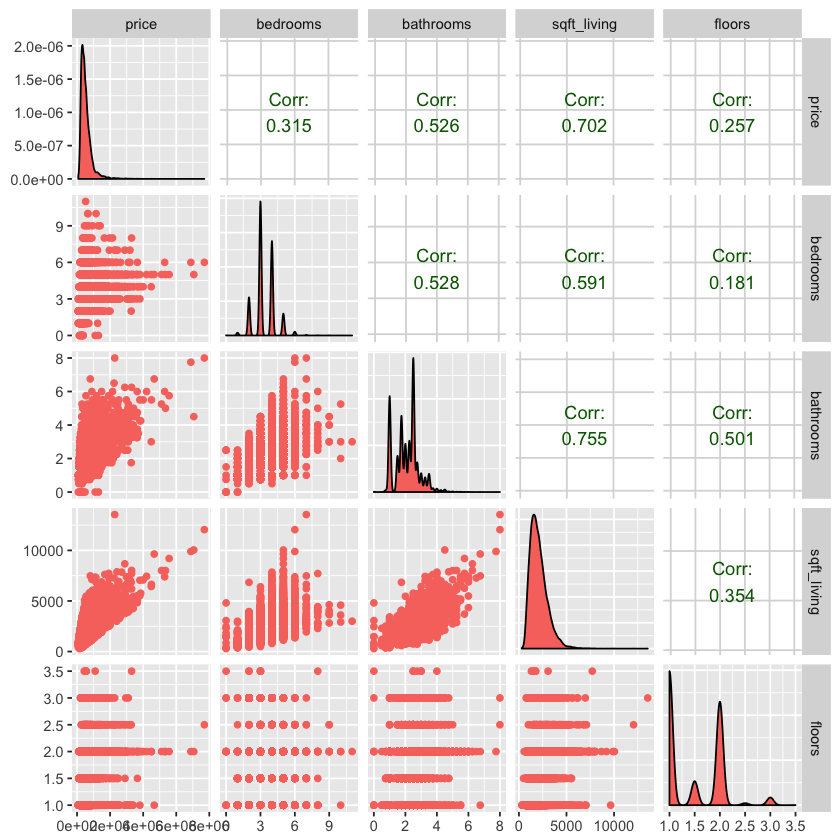

In [98]:
plot_final1

In [99]:
plot_final2 <- ggpairs(data=House3, columns=c(1, 6, 7, 8, 9),
                       mapping = aes(color = "dark green"),
                       axisLabels="show")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


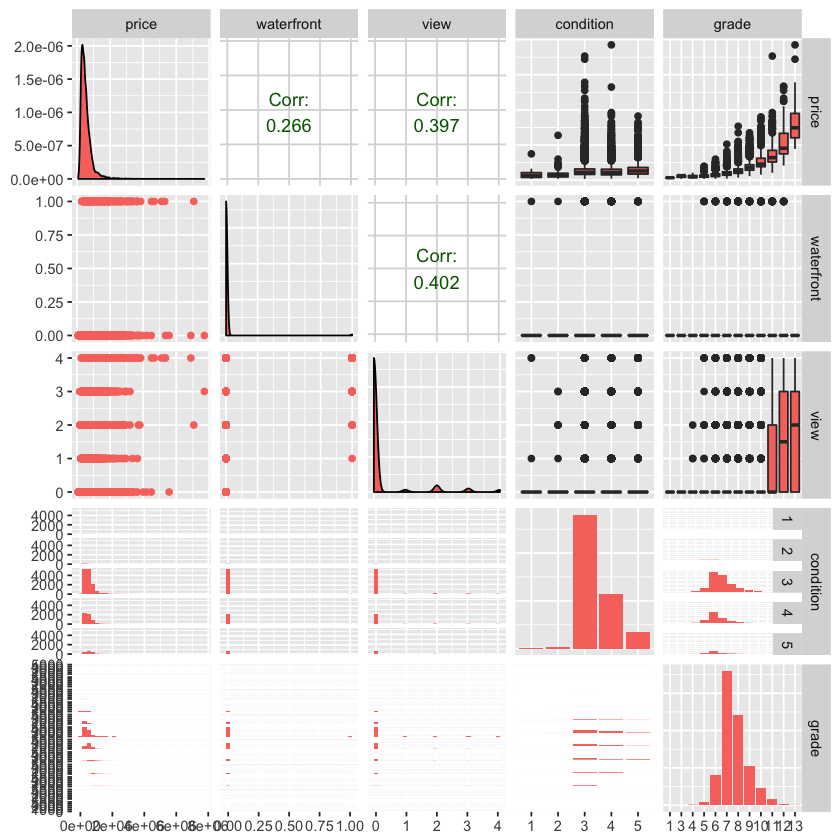

In [100]:
plot_final2

## Multicollinearity


## quantitive vars : bedrooms, bathrooms, sqft_living, floor are highly related.
## grade is also higly related with these four variables, but it's quality variable, so let's consider it separately now. 

## If corr between variables is high(> 0.7) -> It might cause multicollinearity problem.

## Corr(price ~ bedrooms, bathrooms, sqft_living, floor)

## corr between sqft_living vs bedrooms : 0.591
# corr between sqft_living vs bathrooms : 0.755(*)
#### corr between sqft_living vs floors : 0.354
## corr between bedrooms vs bathrooms :0.526
#### corr between bedrooms vs floors : 0.257
## corr between bathrooms vs floors : 0.501

## Let's make new variable by using four variables(bedrooms, bathrooms, sqft_living, floor)

## I use corr_value between price and each variables as coefficient=slope 

In [101]:
House3$quan_spec <- (0.315*House3$bedrooms + 0.526*House3$bathrooms + 0.702*House3$sqft_living + 0.257*House3$floors)

In [102]:
House4 <- as.data.frame(House3)
House4[2:5]<- NULL

In [103]:
DT::datatable(round(cor(House4), digits = 3)) 

ERROR: Error in cor(House4): 'x' must be numeric


## the most hightest corr betweens ind_vars is 0.402 (waterfront & view)
## its less than 0.7 -> it seems fine to put these in regression model.


## Normality

In [104]:
psych::describe(House4$quan_spec) ## skew 1.47 kurtosis 5.23
psych::describe(House4$grade) ## skew 0.77 kurtosis 1.17
psych::describe(House4$waterfront) ## skew 11.38 kurtosis 127.59
psych::describe(House4$view) ## skew 3.4 kurtosis 10.89

vars n     mean     sd       median   trimmed  mad      min     max     
X1 1    21613 1462.647 645.2694 1343.777 1395.608 564.3139 203.837 9512.264
   range    skew     kurtosis se      
X1 9308.427 1.470222 5.234906 4.389181

Warning message in mean.default(x, na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”

ERROR: Error in median.default(x, na.rm = na.rm): need numeric data


## check the skewness and kurtosis to easy to check the normality of each vars.
## Only grade can be used according to this.
## We already modified and got rid of many variables to make the good pricing model.
## If we delete these three variables, there are no more variables to make the reg model. 
## Even if it's not satisfy normality assumption, I'm going to use this vars which have pretty good corr with price.


## making multiple linear regression


In [139]:
House4$grade <- as.numeric(House4$grade)

House4[5]<-NULL

ERROR: Error in `$<-.data.frame`(`*tmp*`, grade, value = numeric(0)): replacement has 0 rows, data has 21613


##  Regression model without cluster dummies

In [140]:
linearmodel1 <- lm(price ~ ., data = House4)


# plot(House4$price, lineartest1$fitted.values, xlab = "Actual price", ylab = "Predicted price", main = "Actual and Prediction comparisson, no clusters")


In [128]:
summary(linearmodel1)


Call:
lm(formula = price ~ ., data = House4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1523447   -37923     9149    42079  3394802 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -6.261e+05  2.284e+04 -27.419   <2e-16 ***
waterfront      2.604e+05  1.074e+04  24.246   <2e-16 ***
view            1.260e+04  1.276e+03   9.869   <2e-16 ***
condition2      3.711e+04  2.458e+04   1.510    0.131    
condition3      3.776e+03  2.272e+04   0.166    0.868    
condition4      1.367e+04  2.275e+04   0.601    0.548    
condition5      2.525e+04  2.289e+04   1.103    0.270    
price_per_sqft  2.015e+03  8.071e+00 249.696   <2e-16 ***
quan_spec       4.243e+02  1.396e+00 303.894   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 124200 on 21604 degrees of freedom
Multiple R-squared:  0.8856,	Adjusted R-squared:  0.8855 
F-statistic: 2.09e+04 on 8 and 21604 DF,  p-value: < 2.2e-16


## step 1 ## 
## H0 : linear regression model is not valid.
## H1 : not H0

## F-statistic:  7733 on 4 and 21608 DF,  p-value: < 2.2e-16
## Accept H1 => This linear regression model is valid.

## ster 2 ##
## H0 : Each independent variables do not have influence on dependent variable;price.
## H1 : not H0

In [109]:
#                 Estimate Std. Error t value Pr(>|t|)    
#  waterfront   5.901e+05  2.022e+04   29.18   <2e-16 ***
#  view         7.058e+04  2.372e+03   29.75   <2e-16 ***
#  grade        9.450e+04  2.111e+03   44.76   <2e-16 ***
#  quan_spec    2.360e+02  3.882e+00   60.81   <2e-16 ***

## every p-value is less than 0.05
## It's okay to use all variables in this model.

## For just in case, let's do valiable selection

In [110]:
model.forward = step(linearmodel1, direction = "forward")
model.backward = step(linearmodel1, direction = "backward")
model.stepwise = step(linearmodel1, direction ="both")

Start:  AIC=507038
price ~ waterfront + view + condition + price_per_sqft + quan_spec

Start:  AIC=507038
price ~ waterfront + view + condition + price_per_sqft + quan_spec

                 Df  Sum of Sq        RSS    AIC
<none>                         3.3331e+14 507038
- condition       4 1.0656e+12 3.3437e+14 507099
- view            1 1.5025e+12 3.3481e+14 507133
- waterfront      1 9.0695e+12 3.4238e+14 507616
- price_per_sqft  1 9.6191e+14 1.2952e+15 536373
- quan_spec       1 1.4248e+15 1.7581e+15 542977
Start:  AIC=507038
price ~ waterfront + view + condition + price_per_sqft + quan_spec

                 Df  Sum of Sq        RSS    AIC
<none>                         3.3331e+14 507038
- condition       4 1.0656e+12 3.3437e+14 507099
- view            1 1.5025e+12 3.3481e+14 507133
- waterfront      1 9.0695e+12 3.4238e+14 507616
- price_per_sqft  1 9.6191e+14 1.2952e+15 536373
- quan_spec       1 1.4248e+15 1.7581e+15 542977


## each method brings the same value of AIC : 534679.9 and use all variables.
## I will go with the linearmodel1 without changing anything.

## Accept H1 => Each independent variables have influence on dependent variable;price.

## step 3 ##

#  waterfront   5.901e+05  
#  view         7.058e+04  
#  grade        9.450e+04  
#  quan_spec    2.360e+02 

## When each indep_var increases by one unit, price will increase by upper amount of dollars.

## step 4 ##
## price = -4.552e+05 + 5.901e+05*waterfront + 7.058e+04*view + 9.450e+04*grade + 2.360e+02*quan_spec

## prediction model
# predict(linearmodel1, newdata=data.frame())
# predict(linearmodel1, newdata=data.frame(), interval = "predict")

## step 5 ##

## Multiple R-squared : 0.5887
## 0.589 => 0.589*100(%) = 58.9%
## This pricing model(or this four variables) can explain 58.9% of the difference of price.

# check the multicollinearity of this reg model


In [111]:
car::vif(linearmodel1)

GVIF     Df GVIF^(1/(2*Df))
waterfront     1.209531 1  1.099787       
view           1.340166 1  1.157655       
condition      1.029084 4  1.003590       
price_per_sqft 1.105420 1  1.051390       
quan_spec      1.137017 1  1.066310

# waterfront   view      grade    quan_spec 
# 1.193124   1.288156   2.400023   2.445779 

## there is no problem of multicollinearity

## Standardized Coefficients
## comparsion of the size of influence of each vars.

In [113]:
lm.beta::lm.beta(linearmodel1)


Call:
lm(formula = price ~ ., data = House4)

Standardized Coefficients::
   (Intercept)     waterfront           view     condition2     condition3 
   0.000000000    0.061367042    0.026292055    0.008981881    0.004908115 
    condition4     condition5 price_per_sqft      quan_spec 
   0.016385727    0.018522744    0.604179771    0.745755142 


# (Intercept)  waterfront        view       grade   quan_spec 
#  0.0000000   0.1390695   0.1473213   0.3024939   0.4148831 


## To use this reg, I shoud check the indepence of residuals
## Durbin-Watson test
## H0 : residual ~ Normality
## H1 : not H0

In [114]:
dwtest(linearmodel1)


	Durbin-Watson test

data:  linearmodel1
DW = 1.9871, p-value = 0.1709
alternative hypothesis: true autocorrelation is greater than 0


# DW = 1.9753, p-value = 0.03469

## p-value < 0.5 -> 
## DW value is close to 2 -> It means this model's residual are independent from each other.

##  Regression model with cluster dummies

In [141]:
House5 <- cbind(House4,dummies)

In [142]:
str(House5)

'data.frame':	21613 obs. of  26 variables:
 $ price         : num  221900 538000 180000 604000 510000 ...
 $ waterfront    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ view          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ condition     : Factor w/ 5 levels "1","2","3","4",..: 3 3 3 5 3 3 3 3 3 3 ...
 $ price_per_sqft: num  188 209 234 308 304 ...
 $ quan_spec     : num  830 1807 542 1379 1182 ...
 $ X1            : num  0 0 0 0 0 0 1 0 0 0 ...
 $ X2            : num  0 0 0 1 0 0 0 0 0 0 ...
 $ X3            : num  0 0 0 0 1 0 0 0 0 0 ...
 $ X4            : num  0 0 1 0 0 0 0 0 0 0 ...
 $ X5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X6            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X7            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X8            : num  0 1 0 0 0 0 0 0 0 0 ...
 $ X9            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X10           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X11           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X12           : num  0 0 0 0 0 0 0 0 1 0 ...
 $ X13           : num  0 0 0 0 0 0 0 0 0

#Since X1, X2 ... X20 are complementary I removed X20 from the equation, linear regression demands it.

In [143]:
linearmodel2 <- lm(price ~ waterfront + view + grade + quan_spec + X1+X2+X3+X4+X5+X6+X7+X8+X9+X10+X11+X12+X13+X14+X15+X16+X17+X18+X19, data = House5)

ERROR: Error in eval(predvars, data, env): 객체 'grade'를 찾을 수 없습니다


# plot(House4$price, lineartest1$fitted.values, xlab = "Actual price", ylab = "Predicted price", main = "Actual and Prediction comparisson, no clusters")

In [119]:
summary(linearmodel2)

ERROR: Error in summary(linearmodel2): 객체 'linearmodel2'를 찾을 수 없습니다
